In [1]:
# Let's start with some standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import scipy.stats

from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Downloading and unzipping dataset
# Only need to run once

#!cd data/ && kaggle competitions download -c titanic
#!cd data/ && unzip titanic.zip

In [3]:
# Let's load the data and take a first look
df = pd.read_csv("data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Our primary cross validation method will be K-fold CV
# Since our dataset and models will be small, we'll have resources to train several models to estimate model variance
# Because of this, we won't have an individual val set - we're safe to do EDA on the whole given dataset

In [5]:
# Let's look at a summary of the data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Get a list of features
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
# 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'
# PassengerId - int64
# Survived - int64 (binary)
# Pclass - int64 (ternary)
# Name - string
# Sex - string (binary)
# Age - float64
# SibSp - int64
# Parch - int64
# Ticket - string
# Fare - float64
# Cabin - string
# Embarked - string (ternary)

# Types to consider: int, int (class, binary, ternary), string, string (class, binary, ternary), float

def EDA_1D(col):
    num_unique_values = len(col.unique())
    print(f"Name: {col.name}")
    print(f"dtype: {col.dtype}")
    print(f"Num unique values: {num_unique_values}")
    print(f"Num missing values: {col.isnull().sum()}")
    print(col.describe())
    if col.dtype == np.int64:
        if num_unique_values < 10:
            print("class int")
            cnts = col.value_counts(dropna=False)
            cnts.plot(kind='bar')
            plt.ylabel("freq")
            plt.title("Bar")
            plt.show()
        else:
            plt.boxplot(col.dropna())
            plt.ylabel(col.name)
            plt.title("Boxplot")
            plt.show()
            col.hist()
            plt.ylabel("freq")
            plt.xlabel(col.name)
            plt.title("Histogram")
            plt.show()
    elif col.dtype == np.float64:
        
        print(f"Skewness: {col.skew()}")
        print(f"Kurtosis: {col.kurt()}")
        plt.boxplot(col.dropna())
        plt.ylabel(col.name)
        plt.title("Boxplot")
        plt.show()
        col.hist()
        plt.title("Histogram")
        plt.ylabel("freq")
        plt.xlabel(col.name)
        plt.show()
        
    elif col.dtype == "object":
        # it's a string
        if num_unique_values < 10:
            cnts = col.value_counts()
            cnts.plot(kind='bar')
            plt.ylabel("freq")
            plt.title("Bar")
            plt.show()
        else:
            words = " ".join(col.dropna())
            name_word_cnts = Counter(words.split())
            print(f"Most common words: {name_word_cnts.most_common(20)}")
            wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='#73B8E9', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(words)
            plt.figure(figsize=(12, 8))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis('off')
            plt.show()

In [8]:
# Get total number of passengers
N = len(df)

0       1
1       2
2       3
3       4
4       5
     ... 
95     96
96     97
97     98
98     99
99    100
Name: PassengerId, Length: 100, dtype: int64
Name: PassengerId
dtype: int64
Num unique values: 891
Num missing values: 0
count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: PassengerId, dtype: float64


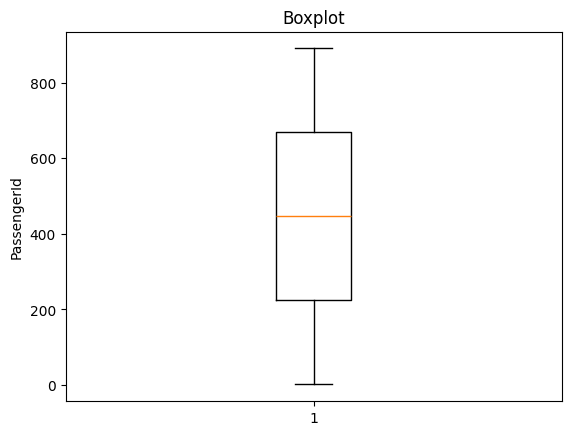

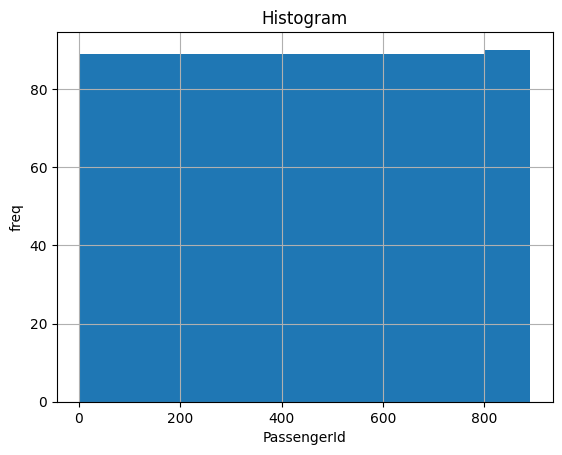

In [9]:
# First, let's look at passenger id
# It appears like it might just be a linear increment
print(df.PassengerId.head(100))

# Let's confirm
for n in range(N):
    assert((n+1) == df.PassengerId[n])
# Looks like we're good to go
EDA_1D(df.PassengerId)

Name: Survived
dtype: int64
Num unique values: 2
Num missing values: 0
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
class int


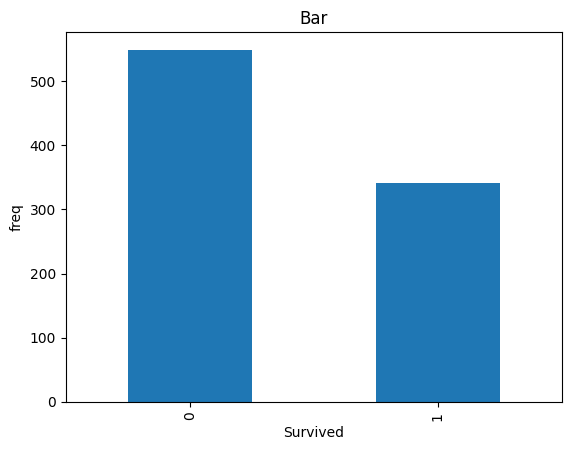

In [10]:
# Next, let's look at the Survived column
# This is our y - the value we're trying to predict
# Let's confirm we're only getting binary values
assert([0,1] in df.Survived.unique())
EDA_1D(df.Survived)
# Less than 40% of people in this dataset survived

Name: Pclass
dtype: int64
Num unique values: 3
Num missing values: 0
count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64
class int


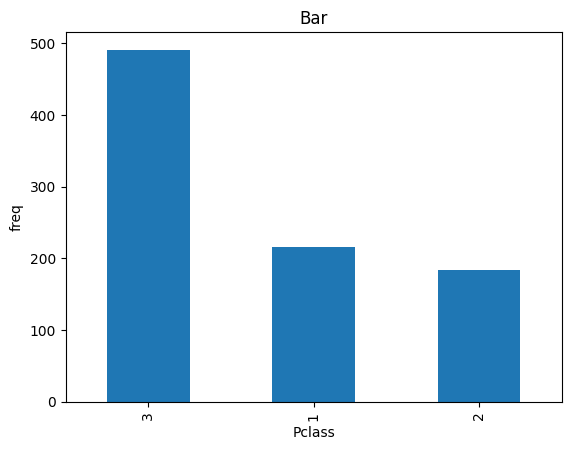

In [11]:
# Next - Pclass, which is the ticket class
# Looks like it's a ternary feature
# When we start doing preprocessing, we need to one-hot encode this
EDA_1D(df.Pclass)

Name: Name
dtype: object
Num unique values: 891
Num missing values: 0
count                         891
unique                        891
top       Braund, Mr. Owen Harris
freq                            1
Name: Name, dtype: object
Most common words: [('Mr.', 517), ('Miss.', 182), ('Mrs.', 125), ('William', 62), ('John', 44), ('Master.', 40), ('Henry', 33), ('James', 24), ('Charles', 23), ('George', 22), ('Thomas', 21), ('Edward', 18), ('Joseph', 16), ('Johan', 15), ('Frederick', 15), ('Mary', 13), ('Richard', 13), ('Samuel', 13), ('Arthur', 13), ('Alfred', 12)]


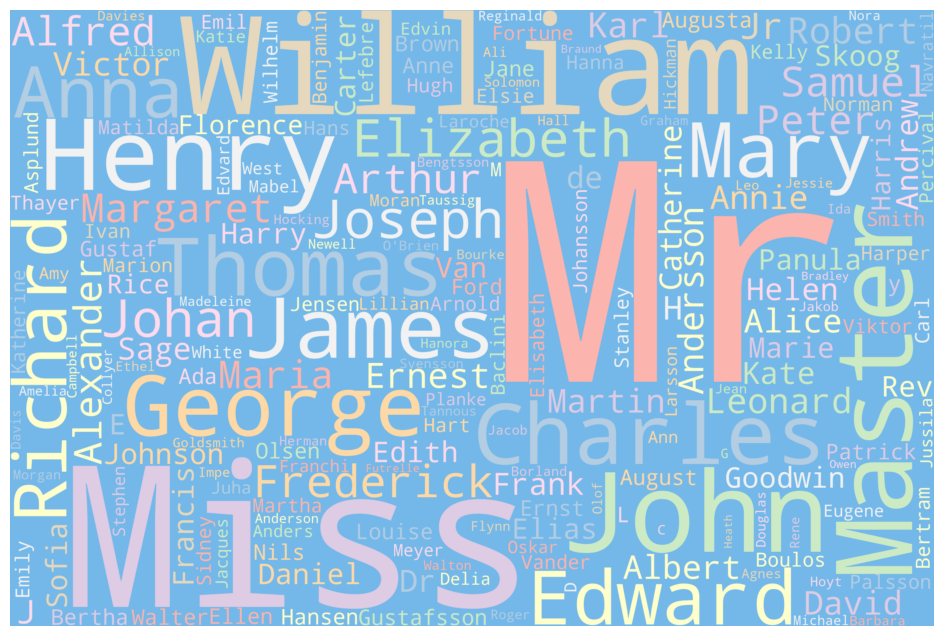

In [12]:
# Next, let's look at names
# Confirmed all names are unique
# I will probably not dive too deep into text features until later
assert(df.Name.is_unique)

# Let's get the most words (first names, last names, prefix, suffix, etc.)
# Let's also build a word cloud
EDA_1D(df.Name)

Name: Sex
dtype: object
Num unique values: 2
Num missing values: 0
count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object


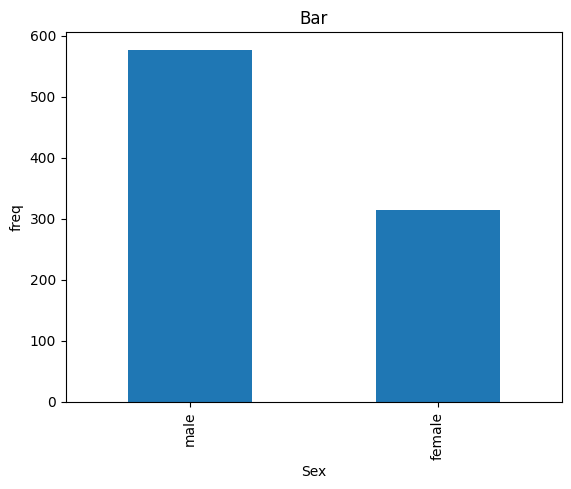

In [13]:
# Next is Sex
# Let's confirm if it's binary
EDA_1D(df.Sex)
# We'll encode these into a binary 0/1 feature later

Name: Age
dtype: float64
Num unique values: 89
Num missing values: 177
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
Skewness: 0.38910778230082704
Kurtosis: 0.17827415364210353


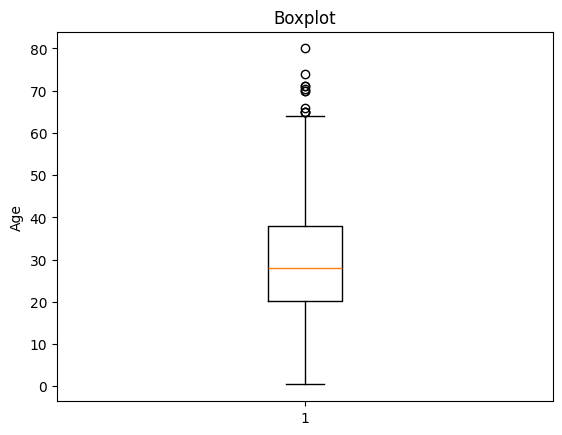

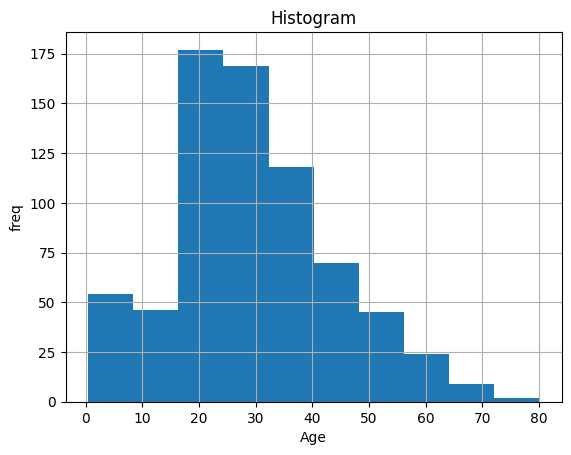

In [14]:
# Interestingly, we have fractional ages here
EDA_1D(df.Age)
# May be a skewed normal distribution?
# May want to create feature bins for age groups (baby, child, adult, etc.)

Name: SibSp
dtype: int64
Num unique values: 7
Num missing values: 0
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64
class int


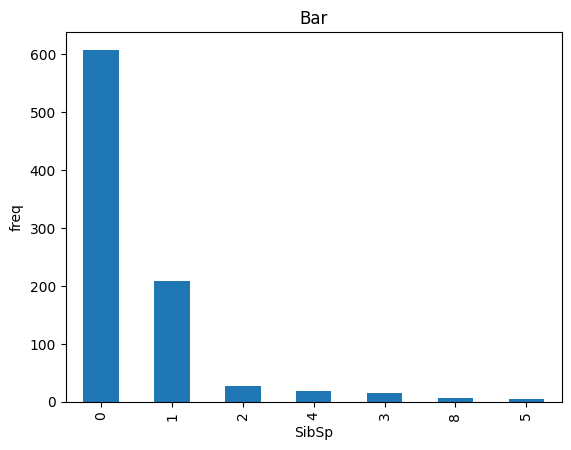

In [15]:
# Next is number of siblings / spouses on-board
EDA_1D(df.SibSp)
# Could split this into a binary feature - i.e. are you in a family on the Titanic?
# Another thing to note - we seem to have five folks in a family of 5 (are they in the same family?) and 7 folks in a family of 8.
# But one of the eight isn't on the list?
# Maybe it's in the test set
# This feature MAY cause overfitting since we're going to edge of the range for this feature

Name: Parch
dtype: int64
Num unique values: 7
Num missing values: 0
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64
class int


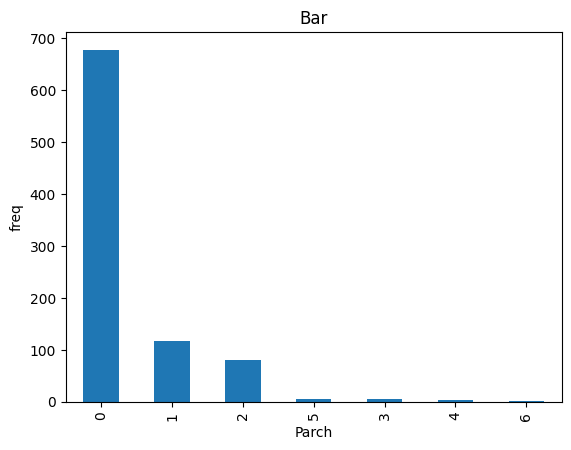

In [16]:
# Next is num parents / children on Titanic
EDA_1D(df.Parch)
# Most folks don't have parents or children
# The most common non-zero value is 1
# Could split this up into categorical features? 
# Maybe just 0, 1, 2, and 2+?

[('PC', 60), ('C.A.', 27), ('STON/O', 12), ('2.', 12), ('A/5', 10), ('W./C.', 9), ('SOTON/O.Q.', 8), ('CA.', 8), ('A/5.', 7), ('347082', 7), ('1601', 7), ('SOTON/OQ', 7), ('2343', 7), ('STON/O2.', 6), ('3101295', 6), ('CA', 6), ('2144', 6), ('347088', 6), ('382652', 5), ('S.O.C.', 5), ('14879', 5), ('C', 5), ('SC/PARIS', 5), ('F.C.C.', 5), ('349909', 4), ('347077', 4), ('19950', 4), ('SC/Paris', 4), ('6608', 4), ('4133', 4), ('LINE', 4), ('113781', 4), ('17421', 4), ('17757', 4), ('113760', 4), ('2666', 4), ('347742', 3), ('PP', 3), ('2123', 3), ('A/4.', 3)]
count    8.870000e+02
mean     2.983284e+05
std      6.576144e+05
min      3.000000e+00
25%      1.487900e+04
50%      1.122770e+05
75%      3.470820e+05
max      3.101317e+06
dtype: float64


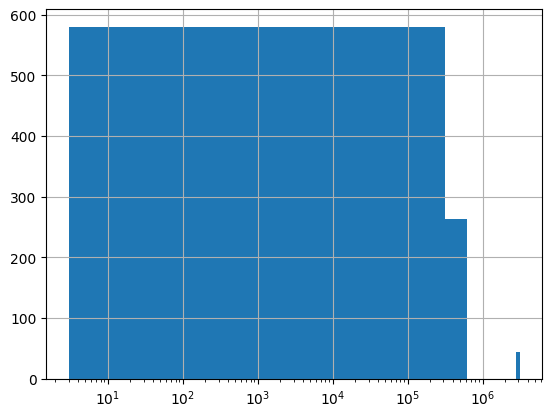

In [17]:
# Next is ticket id
# This seems more like a string?
# Let's extract the most common words
df.Ticket.head()
ticket_words_list = " ".join(df.Ticket).split()
ticket_word_cnts = Counter(ticket_words_list)
print(ticket_word_cnts.most_common(40))
# Surpringly some of these are words, but some are numbers too - what's the relation? Do families share ticket numbers?
# Let's grab the numbers and make a histogram
ticket_nums_series = pd.Series([int(n) for n in ticket_words_list if n.isnumeric()])
plt.xscale('log')
ticket_nums_series.hist()
print(ticket_nums_series.describe())
# Looks to mostly look like a linear increment with some values missing

Name: Fare
dtype: float64
Num unique values: 248
Num missing values: 0
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
Skewness: 4.787316519674893
Kurtosis: 33.39814088089868


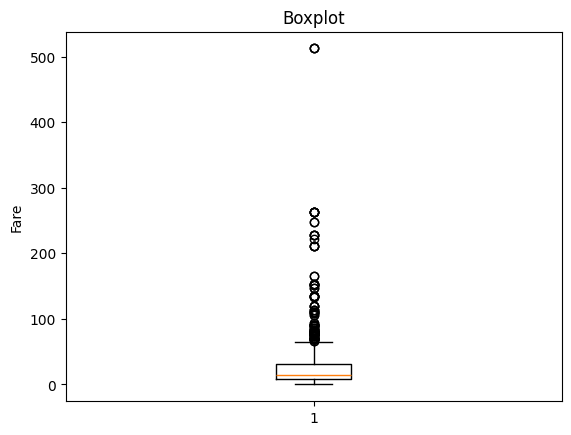

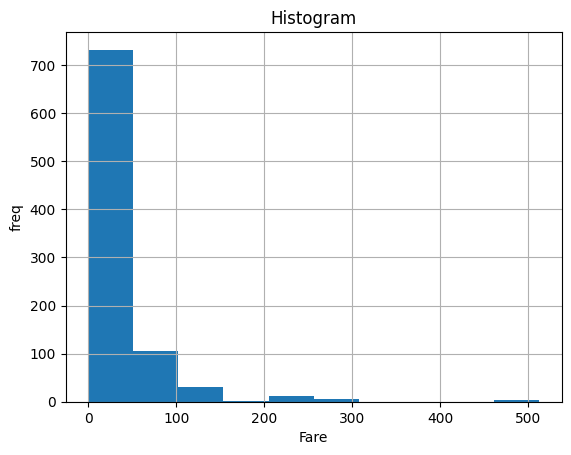

In [18]:
# Next let's look at fare
# Looks like some people got in for free!
EDA_1D(df.Fare)
# Might be good to bin these values - there are defintely some standard price values

In [19]:
# Almost done with univariate EDA - let's look at cabin numbers next
print(df.Cabin.value_counts())
print(df.Cabin.describe())
# What are these letters? Floor numbers? Could be correlated with class
# Looks like we also have some missing values in here
print(f"Number of non-null values: {len(df.Cabin.dropna())} / {len(df.Cabin)}")
# We can probably include an is nan feature for missing cabin numbers
text = " ".join(df.Cabin.dropna())
Counter(c for c in text.lower() if c.isalpha())

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64
count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object
Number of non-null values: 204 / 891


Counter({'c': 71, 'b': 64, 'd': 34, 'e': 33, 'a': 15, 'f': 13, 'g': 7, 't': 1})

Name: Embarked
dtype: object
Num unique values: 4
Num missing values: 2
count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object


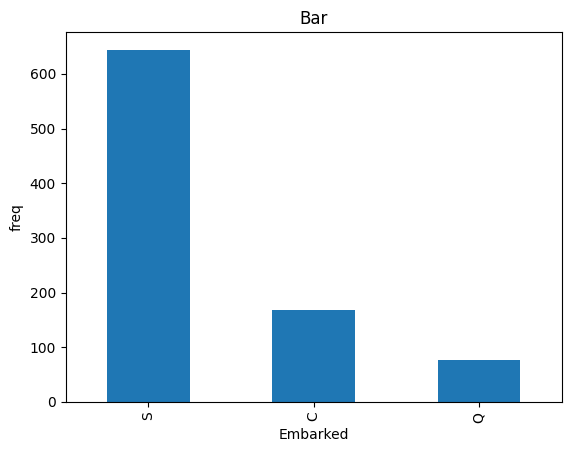

In [20]:
# And lastly - embarked, which encodes where the port the person boarded on
EDA_1D(df.Embarked)

In [21]:
# PassengerId - int64
# Survived - int64 (binary)
# Pclass - int64 (ternary)
# Name - string
# Sex - string (binary)
# Age - float64
# SibSp - int64
# Parch - int64
# Ticket - string
# Fare - float64
# Cabin - string
# Embarked - string (ternary)

# 5 types: int, int class, string, string class, float
# pair types:
# 1. int, int
# 2. int, int class
# 3. int, string
# 4. int, string class
# 5. int, float
# 6. int class, int class
# 7. int class, string
# 8. int class, string class
# 9. int class, float
# 10. string, string
# 11. string, string class
# 12. string, float
# 13. string class, string class
# 14. string class, float
# 15. float, float

def EDA_2D(col1, col2):
    if col1.dtype == np.int64 and len(col1.unique()) >= 10:
        col1_type = "int"
    elif col1.dtype == np.int64 and len(col1.unique()) < 10:
        col1_type = "int_class"
    elif col1.dtype  == "object" and len(col1.unique()) >= 10:
        col1_type = "string"
    elif col1.dtype  == "object" and len(col1.unique()) < 10:
        col1_type = "string_class"
    elif col1.dtype == float:
        col1_type = "float"
    else:
        assert(False)
        
    if col2.dtype == np.int64 and len(col2.unique()) >= 10:
        col2_type = "int"
    elif col2.dtype == np.int64 and len(col2.unique()) < 10:
        col2_type = "int_class"
    elif col2.dtype  == "object" and len(col2.unique()) >= 10:
        col2_type = "string"
    elif col2.dtype  == "object" and len(col2.unique()) < 10:
        col2_type = "string_class"
    elif col2.dtype == float:
        col2_type = "float"
    else:
        assert(False)

    print(f"Feature Pair: {col1.name, col2.name}")
    print(f"Datatypes: {col1_type, col2_type}")

    def EDA_2D_int_int(col1, col2):
        print(f"Correlation: {col1.corr(col2)}")
        plt.scatter(col1, col2)
        plt.xlabel(col1.name)
        plt.ylabel(col2.name)
        
    def EDA_2D_int_intclass(col1, col2):
        print(f"Correlation: {col1.corr(col2)}")
        class_list = []
        intclasses = col2.unique()
        print(f"all:")
        print(f"Skewness: {col1.skew()}")
        print(f"Kurtosis: {col1.kurt()}")
        for intclass in intclasses:
            class_list.append(col1[col2 == intclass])
            class_list[-1].hist(alpha=0.5, label=intclass)
            print(f"{intclass:}")
            print(f"Skewness: {class_list[-1].skew()}")
            print(f"Kurtosis: {class_list[-1].kurt()}")
        plt.legend()
        plt.show()
        plt.boxplot(class_list, labels=intclasses)
        plt.ylabel(col1.name)
        plt.xlabel(col2.name)
        plt.show()
        
    def EDA_2D_int_string(col1, col2):
        min_val = col1.min()
        max_val = col1.max()
        for c in [min_val, max_val]:
            print(f"{c}:{Counter(' '.join(col2[col1==c].dropna()).split()).most_common(20)}")
            
    def EDA_2D_int_stringclass(col1, col2):
        class_list = []
        classes = col2.unique()
        print(f"all:")
        print(f"Skewness: {col1.skew()}")
        print(f"Kurtosis: {col1.kurt()}")
        for c in classes:
            class_list.append(col1[col2 == c])
            class_list[-1].hist(alpha=0.5, label=c)
            print(f"{c:}")
            print(f"Skewness: {class_list[-1].skew()}")
            print(f"Kurtosis: {class_list[-1].kurt()}")
        plt.legend()
        plt.show()
        plt.boxplot(class_list, labels=classes)
        plt.ylabel(col1.name)
        plt.xlabel(col2.name)
        plt.show()
        
    def EDA_2D_int_float(col1, col2):
        print(f"Correlation: {col1.corr(col2)}")
        plt.scatter(col1, col2)
        plt.xlabel(col1.name)
        plt.ylabel(col2.name)
        
    def EDA_2D_intclass_intclass(col1, col2):
        print(f"Correlation: {col1.corr(col2)}")
        col1_classes = col1.unique()
        col2_classes = col2.unique()
        print(pd.concat([col1, col2], axis=1).value_counts())
        
    def EDA_2D_intclass_string(col1, col2):
        print(pd.concat([col1, col2], axis=1).value_counts())
        classes = col1.unique()
        words_list = " ".join(col2.dropna()).split()
        word_cnts = Counter(words_list)
        top_words = ticket_word_cnts.most_common(50)
        
        for c in classes:
            print(f"{c}:{Counter(' '.join(col2[col1==c].dropna()).split()).most_common(20)}")
            
    def EDA_2D_intclass_stringclass(col1, col2):
        col1_classes = col1.unique()
        col2_classes = col2.unique()
        print(pd.concat([col1, col2], axis=1).value_counts())
        
    def EDA_2D_intclass_float(col1, col2):
        print(f"Correlation: {col1.corr(col2)}")

        
        col1_classes = col1.unique()
        boxplots = []

        print(f"all:")
        print(f"Skewness: {col2.skew()}")
        print(f"Kurtosis: {col2.kurt()}")
        
        for c in col1_classes:
            boxplots.append(col2[col1 == c].dropna())
            col2[col1 == c].dropna().hist(alpha=0.5, label=c)
            print(f"{c:}")
            print(f"Skewness: {col2[col1 == c].skew()}")
            print(f"Kurtosis: {col2[col1 == c].kurt()}")
        plt.legend()
        plt.show()
        plt.boxplot(boxplots, labels=col1_classes)
        plt.xlabel(col1.name)
        plt.ylabel(col2.name)
        plt.show()
        
    def EDA_2D_string_string(col1, col2):
        print(pd.concat([col1, col2], axis=1).head())
        print(pd.concat([col1, col2], axis=1).tail())
        
    def EDA_2D_string_stringclass(col1, col2):
        classes = col2.unique()
        for c in classes:
            print(f"{c}:{Counter(' '.join(col1[col2==c].dropna()).split()).most_common(20)}")
        
    def EDA_2D_string_float(col1, col2):
        min_val = col2.min()
        max_val = col2.max()
        for c in [min_val, max_val]:
            print(f"{c}:{Counter(' '.join(col1[col2==c].dropna()).split()).most_common(20)}")
            
    def EDA_2D_stringclass_stringclass(col1, col2):
        col1_classes = col1.unique()
        col2_classes = col2.unique()
        print(pd.concat([col1, col2], axis=1).value_counts())
        
    def EDA_2D_stringclass_float(col1, col2):
        col1_classes = col1.unique()
        boxplots = []
        print(f"all:")
        print(f"Skewness: {col2.skew()}")
        print(f"Kurtosis: {col2.kurt()}")
        for c in col1_classes:
            boxplots.append(col2[col1 == c].dropna())
            col2[col1 == c].dropna().hist(alpha=0.5, label=c)
            print(f"{c:}")
            print(f"Skewness: {col2[col1 == c].skew()}")
            print(f"Kurtosis: {col2[col1 == c].kurt()}")
        plt.legend()
        plt.show()
        plt.boxplot(boxplots, labels=col1_classes)
        plt.xlabel(col1.name)
        plt.ylabel(col2.name)
        plt.show()
        
    def EDA_2D_float_float(col1, col2):
        print(f"Correlation: {col1.corr(col2)}")
        plt.scatter(col1, col2)
        plt.xlabel(col1.name)
        plt.ylabel(col2.name)
        

    if col1_type == "int" and col2_type == "int":
        EDA_2D_int_int(col1, col2)
    elif col1_type == "int" and col2_type == "int_class":
        EDA_2D_int_intclass(col1, col2)
    elif col1_type == "int" and col2_type == "string":
        EDA_2D_int_string(col1, col2)
    elif col1_type == "int" and col2_type == "string_class":
        EDA_2D_int_stringclass(col1, col2)
    elif col1_type == "int" and col2_type == "float":
        EDA_2D_int_float(col1, col2)  
    elif col1_type == "int_class" and col2_type == "int":
        EDA_2D_int_intclass(col2, col1)
    elif col1_type == "int_class" and col2_type == "int_class":
        EDA_2D_intclass_intclass(col1, col2)
    elif col1_type == "int_class" and col2_type == "string":
        EDA_2D_intclass_string(col1, col2)
    elif col1_type == "int_class" and col2_type == "string_class":
        EDA_2D_intclass_stringclass(col1, col2)
    elif col1_type == "int_class" and col2_type == "float":
        EDA_2D_intclass_float(col1, col2)  
    elif col1_type == "string" and col2_type == "int":
        EDA_2D_int_string(col2, col1)
    elif col1_type == "string" and col2_type == "int_class":
        EDA_2D_intclass_string(col2, col1)
    elif col1_type == "string" and col2_type == "string":
        EDA_2D_string_string(col1, col2)
    elif col1_type == "string" and col2_type == "string_class":
        EDA_2D_string_stringclass(col1, col2)
    elif col1_type == "string" and col2_type == "float":
        EDA_2D_string_float(col1, col2)
    elif col1_type == "string_class" and col2_type == "int":
        EDA_2D_int_stringclass(col2, col1)
    elif col1_type == "string_class" and col2_type == "int_class":
        EDA_2D_intclass_stringclass(col2, col1)
    elif col1_type == "string_class" and col2_type == "string":
        EDA_2D_string_stringclass(col2, col1)
    elif col1_type == "string_class" and col2_type == "string_class":
        EDA_2D_stringclass_stringclass(col1, col2)
    elif col1_type == "string_class" and col2_type == "float":
        EDA_2D_stringclass_float(col1, col2)
    elif col1_type == "float" and col2_type == "int":
        EDA_2D_int_float(col2, col1)
    elif col1_type == "float" and col2_type == "int_class":
        EDA_2D_intclass_float(col2, col1)  
    elif col1_type == "float" and col2_type == "string":
        EDA_2D_string_float(col2, col1)
    elif col1_type == "float" and col2_type == "string_class":
        EDA_2D_stringclass_float(col2, col1)
    elif col1_type == "float" and col2_type == "float":
        EDA_2D_float_float(col1, col2) 
    return

Feature Pair: ('Survived', 'PassengerId')
Datatypes: ('int_class', 'int')
Correlation: -0.0050066607670664915
all:
Skewness: 0.0
Kurtosis: -1.1999999999999997
0
Skewness: 0.00038308640710338213
Kurtosis: -1.2613000533756322
1
Skewness: -0.002004132037526045
Kurtosis: -1.0925491102330063


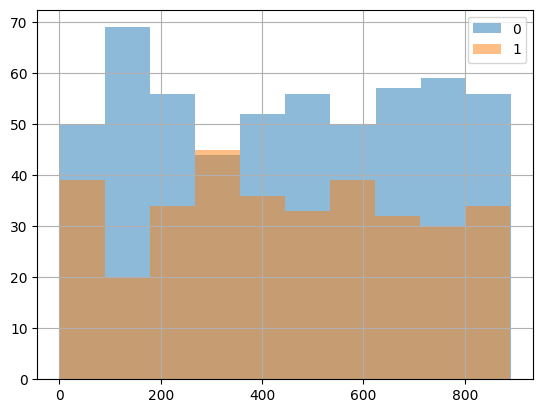

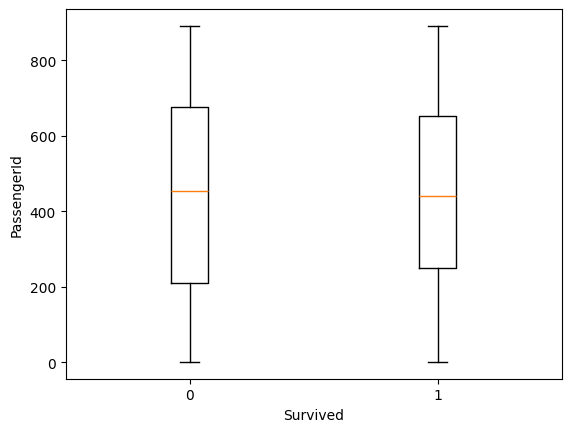

In [22]:
# Next let's start looking at correlations between pairs of variables

# PassengerId, Survived, Pclass, Name, Sex, Age, SibSp,Parch, Ticket, Fare, Cabin, Embarked
# Since Survived is the variable to be predicted, let's first correlate survived with all of the other variables

# 1. Survived, PassengerId
EDA_2D(df.Survived, df.PassengerId)

# There is not much correlation at all between passenger id and survived

In [23]:
# 2. Survived, Pclass

# If we maintain ordering for pclass, we see a weak correlation
# It is negative - meaning higher pclass has lower chance of surviving
# While the survivors seem to be pretty unofrmly distributed between each class, those who perished are often in the lower classes
# When we look at counts for pairs of values, 3rd class is disproportionally represented by 3rd class passengers

EDA_2D(df.Survived, df.Pclass)

Feature Pair: ('Survived', 'Pclass')
Datatypes: ('int_class', 'int_class')
Correlation: -0.3384810359610148
Survived  Pclass
0         3         372
1         1         136
          3         119
0         2          97
1         2          87
0         1          80
Name: count, dtype: int64


In [24]:
# 3. Survived, Name
EDA_2D(df.Survived, df.Name)

Feature Pair: ('Survived', 'Name')
Datatypes: ('int_class', 'string')
Survived  Name                                     
0         Abbing, Mr. Anthony                          1
1         Brown, Mrs. James Joseph (Margaret Tobin)    1
          Bidois, Miss. Rosalie                        1
          Bing, Mr. Lee                                1
          Bishop, Mr. Dickinson H                      1
                                                      ..
0         Maisner, Mr. Simon                           1
          Mallet, Mr. Albert                           1
          Mangan, Miss. Mary                           1
          Markoff, Mr. Marin                           1
1         de Mulder, Mr. Theodore                      1
Name: count, Length: 891, dtype: int64
0:[('Mr.', 436), ('Miss.', 55), ('William', 41), ('John', 33), ('Mrs.', 26), ('Henry', 23), ('James', 18), ('Master.', 17), ('Charles', 16), ('George', 16), ('Thomas', 14), ('Johan', 13), ('Edward', 12), ('Joseph

In [25]:
# 4. Survived, Sex
# We have a moderate association between sex and survival
# It is negative - meaning males had a lower chance of survival
# Over half of the dataset is males who died
EDA_2D(df.Survived, df.Sex)

Feature Pair: ('Survived', 'Sex')
Datatypes: ('int_class', 'string_class')
Survived  Sex   
0         male      468
1         female    233
          male      109
0         female     81
Name: count, dtype: int64


Feature Pair: ('Survived', 'Age')
Datatypes: ('int_class', 'float')
Correlation: -0.07722109457217755
all:
Skewness: 0.38910778230082704
Kurtosis: 0.17827415364210353
0
Skewness: 0.5855837826738851
Kurtosis: 0.2826456199871803
1
Skewness: 0.18045773625500755
Kurtosis: -0.057601674007564


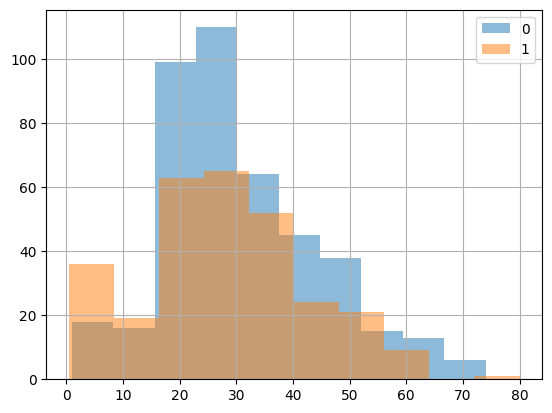

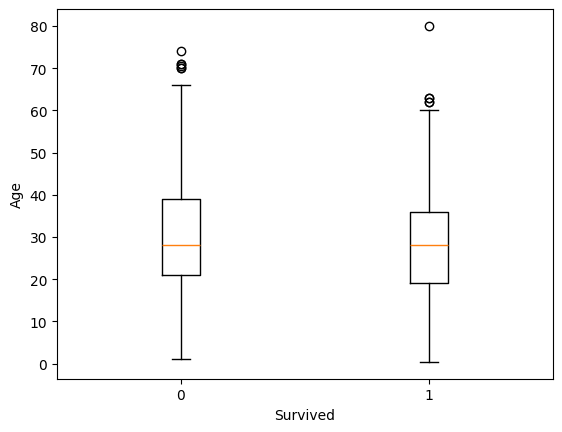

In [26]:
# 5. Survived, Age
# Broadly speaking, there's no association with age and survival
# This is surprising - I would've assumed children would've had a higher chance of survival
# Also that older folks would've had a lower chance of survival - we can break this up more later when we bin ages
EDA_2D(df.Survived, df.Age)

In [27]:
# 6. Survived, SibSp
# Largely there's no correlation if you look at the bulk of the data
# When we look at outliers, the bigger families tended to not survive
# Maybe an interaction term between SibSp and 'isOutlier' could be useful?
# I think it might overfit though and compromise average performance
EDA_2D(df.Survived, df.SibSp)

Feature Pair: ('Survived', 'SibSp')
Datatypes: ('int_class', 'int_class')
Correlation: -0.035322498885735576
Survived  SibSp
0         0        398
1         0        210
          1        112
0         1         97
          2         15
          4         15
1         2         13
0         3         12
          8          7
          5          5
1         3          4
          4          3
Name: count, dtype: int64


In [28]:
# 7. Survived, Parch
# It seems like not survivng is concentrated at 0
# Let's group it 
# Those without parents or siblings were more likely to not survive. Maybe it's correlated with being an adult male?
EDA_2D(df.Survived, df.Parch)

Feature Pair: ('Survived', 'Parch')
Datatypes: ('int_class', 'int_class')
Correlation: 0.0816294070834836
Survived  Parch
0         0        445
1         0        233
          1         65
0         1         53
          2         40
1         2         40
0         4          4
          5          4
1         3          3
0         3          2
          6          1
1         5          1
Name: count, dtype: int64


In [29]:
# 8. Survived, Ticket
# Seems as if some words are more common than others for each class
EDA_2D(df.Survived, df.Ticket)

Feature Pair: ('Survived', 'Ticket')
Datatypes: ('int_class', 'string')
Survived  Ticket   
0         347082       7
          CA. 2343     7
          CA 2144      6
          3101295      6
          347088       6
                      ..
          349249       1
          349251       1
          349252       1
          349253       1
1         WE/P 5735    1
Name: count, Length: 730, dtype: int64
0:[('PC', 21), ('C.A.', 14), ('A/5', 9), ('W./C.', 8), ('347082', 7), ('STON/O', 7), ('2.', 7), ('SOTON/O.Q.', 7), ('CA.', 7), ('2343', 7), ('A/5.', 6), ('3101295', 6), ('CA', 6), ('2144', 6), ('347088', 6), ('SOTON/OQ', 6), ('382652', 5), ('S.O.C.', 5), ('14879', 5), ('349909', 4)]
1:[('PC', 39), ('C.A.', 13), ('1601', 5), ('STON/O', 5), ('2.', 5), ('F.C.C.', 4), ('113760', 4), ('2666', 4), ('STON/O2.', 3), ('347742', 3), ('347077', 3), ('17572', 3), ('110152', 3), ('17755', 3), ('13502', 3), ('17421', 3), ('17757', 3), ('29106', 3), ('17474', 3), ('24160', 3)]


Feature Pair: ('Survived', 'Fare')
Datatypes: ('int_class', 'float')
Correlation: 0.2573065223849622
all:
Skewness: 4.787316519674893
Kurtosis: 33.39814088089868
0
Skewness: 4.55314046934547
Kurtosis: 26.370707228140354
1
Skewness: 3.8627793799441936
Kurtosis: 20.662029528187155


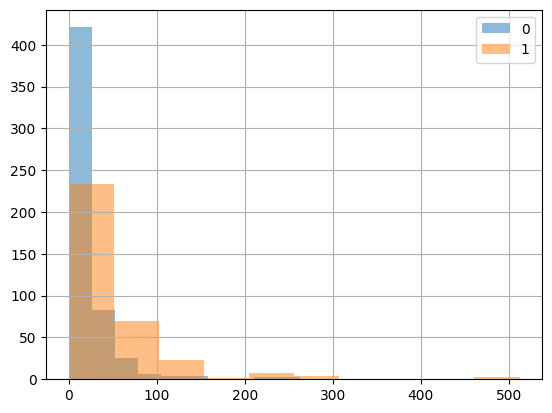

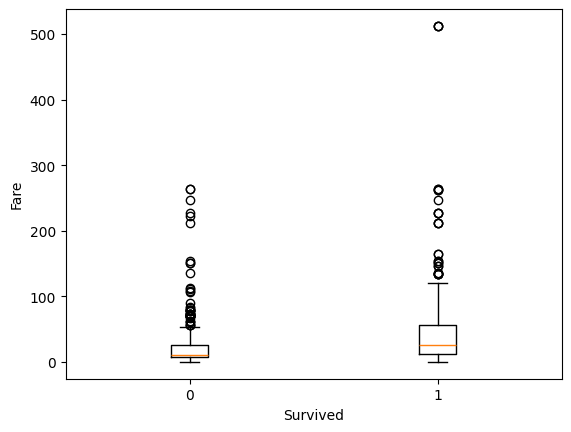

In [30]:
# 9. Survived, Fare
# Seems there's some correlation with fare and survival
EDA_2D(df.Survived, df.Fare)

In [31]:
# 10. Survived, Cabin
EDA_2D(df.Survived, df.Cabin)

Feature Pair: ('Survived', 'Cabin')
Datatypes: ('int_class', 'string')
Survived  Cabin          
1         B96 B98            4
          F33                3
          E101               3
          B5                 2
          B57 B59 B63 B66    2
                            ..
0         C30                1
          C46                1
1         B101               1
          A6                 1
0         A10                1
Name: count, Length: 163, dtype: int64
0:[('F', 3), ('C23', 2), ('C25', 2), ('C27', 2), ('G73', 2), ('D26', 2), ('G6', 2), ('C22', 2), ('C26', 2), ('C124', 2), ('E46', 1), ('B30', 1), ('C83', 1), ('E31', 1), ('A5', 1), ('C110', 1), ('B58', 1), ('B60', 1), ('C123', 1), ('B86', 1)]
1:[('B96', 4), ('B98', 4), ('F33', 3), ('E101', 3), ('G6', 2), ('D33', 2), ('C52', 2), ('B28', 2), ('C23', 2), ('C25', 2), ('C27', 2), ('E33', 2), ('F4', 2), ('F2', 2), ('D36', 2), ('C93', 2), ('D35', 2), ('B77', 2), ('C125', 2), ('B49', 2)]


In [32]:
# 11. Survived, Embarked
EDA_2D(df.Survived, df.Embarked)

Feature Pair: ('Survived', 'Embarked')
Datatypes: ('int_class', 'string_class')
Survived  Embarked
0         S           427
1         S           217
          C            93
0         C            75
          Q            47
1         Q            30
Name: count, dtype: int64


Feature Pair: ('PassengerId', 'Pclass')
Datatypes: ('int', 'int_class')
Correlation: -0.03514399403037978
all:
Skewness: 0.0
Kurtosis: -1.1999999999999997
3
Skewness: 0.026721047144405763
Kurtosis: -1.2637983386717098
1
Skewness: -0.08196060254292167
Kurtosis: -1.0580799670452943
2
Skewness: 0.03959991947503299
Kurtosis: -1.1636744672203447


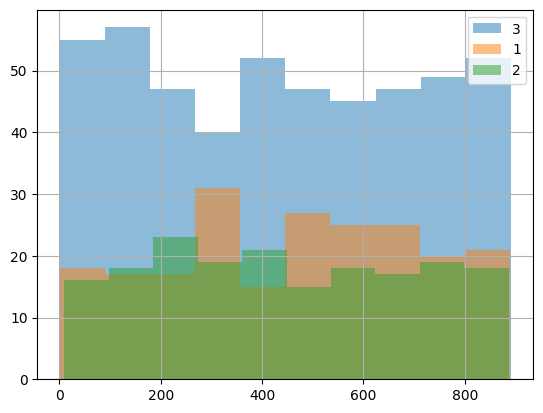

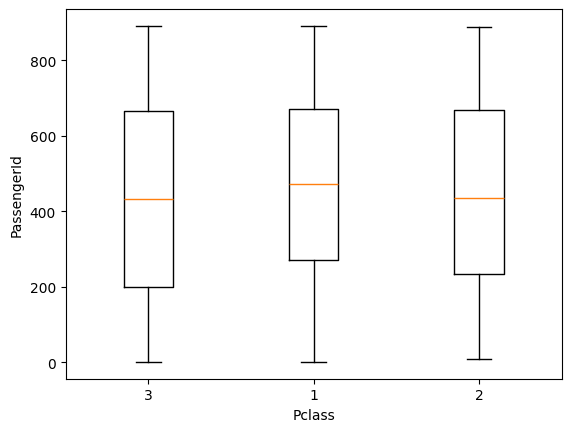

In [33]:
# 12. PassengerId, Pclass
EDA_2D(df.PassengerId, df.Pclass)

In [34]:
# 13. PassengerId, Name
EDA_2D(df.PassengerId, df.Name)

Feature Pair: ('PassengerId', 'Name')
Datatypes: ('int', 'string')
1:[('Braund,', 1), ('Mr.', 1), ('Owen', 1), ('Harris', 1)]
891:[('Dooley,', 1), ('Mr.', 1), ('Patrick', 1)]


Feature Pair: ('PassengerId', 'Sex')
Datatypes: ('int', 'string_class')
all:
Skewness: 0.0
Kurtosis: -1.1999999999999997
male
Skewness: -0.05150043346344771
Kurtosis: -1.2463844386535954
female
Skewness: 0.09476826684459302
Kurtosis: -1.0911858502041736


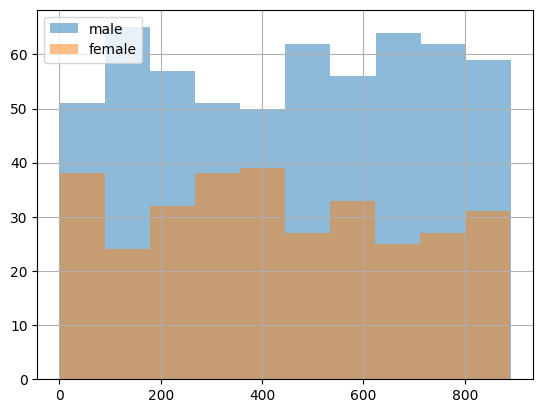

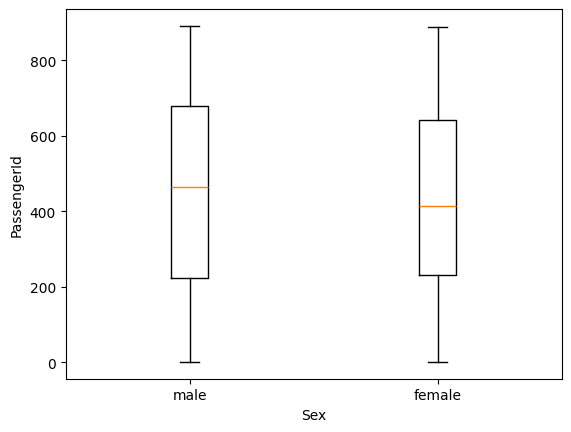

In [35]:
# 14. PassengerId, Sex
EDA_2D(df.PassengerId, df.Sex)

Feature Pair: ('PassengerId', 'Age')
Datatypes: ('int', 'float')
Correlation: 0.03684719786132784


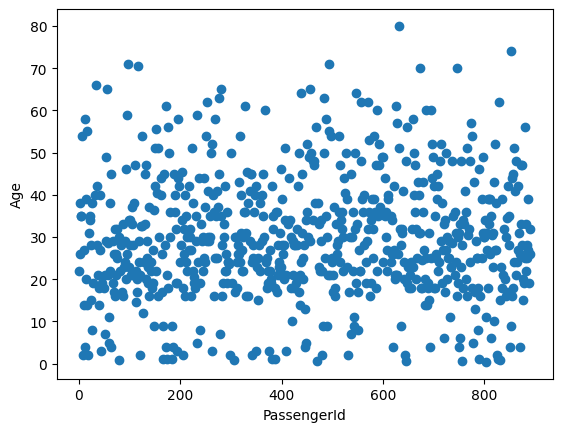

In [36]:
# 15. PassengerId, Age
EDA_2D(df.PassengerId, df.Age)

Feature Pair: ('PassengerId', 'SibSp')
Datatypes: ('int', 'int_class')
Correlation: -0.05752683378444151
all:
Skewness: 0.0
Kurtosis: -1.1999999999999997
1
Skewness: -0.045878176621448614
Kurtosis: -1.1441968485854603
0
Skewness: -0.014551600696755793
Kurtosis: -1.2037790988451318
3
Skewness: 0.48277765175935916
Kurtosis: -1.1531316910962017
4
Skewness: 0.5175778542403677
Kurtosis: -1.3891979212016925
2
Skewness: -0.07132020532662756
Kurtosis: -1.0108249045445223
5
Skewness: 0.11072634534638928
Kurtosis: -1.8997619390125662
8
Skewness: 0.3014104680943592
Kurtosis: -2.650708946418198


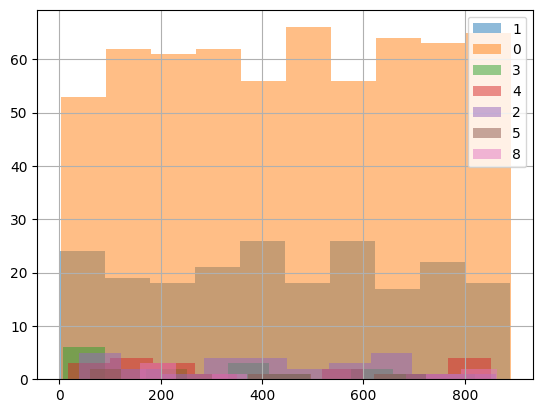

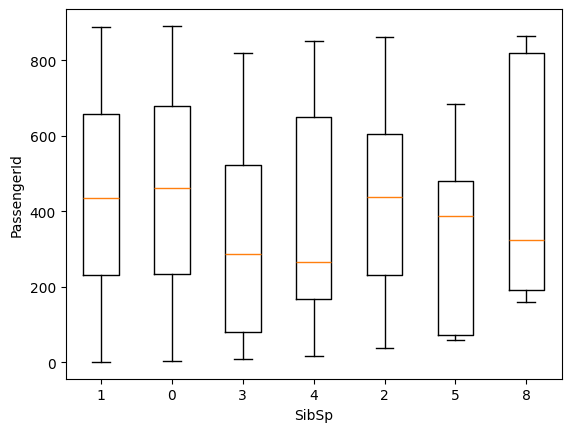

In [37]:
# 16. PassengerId, SibSp
EDA_2D(df.PassengerId, df.SibSp)

Feature Pair: ('PassengerId', 'Parch')
Datatypes: ('int', 'int_class')
Correlation: -0.0016520124027188353
all:
Skewness: 0.0
Kurtosis: -1.1999999999999997
0
Skewness: -0.016651146967820243
Kurtosis: -1.1874301245980239
1
Skewness: 0.009421688141895134
Kurtosis: -1.2801398425976886
2
Skewness: 0.19470862960221388
Kurtosis: -1.142412837040504
5
Skewness: -0.2573217873238506
Kurtosis: -2.6243982237938264
3
Skewness: -1.1527845031422643
Kurtosis: 0.25880435315592365
4
Skewness: -0.5249948677665174
Kurtosis: 0.646305312555052
6
Skewness: nan
Kurtosis: nan


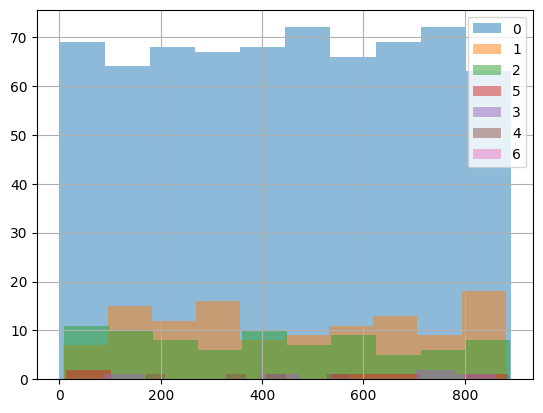

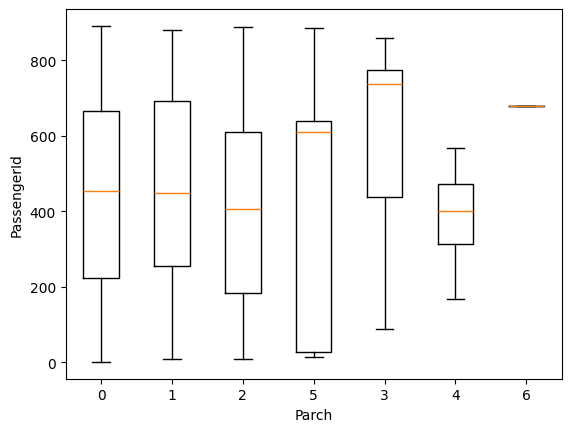

In [38]:
# 17. PassengerId, Parch
EDA_2D(df.PassengerId, df.Parch)

In [39]:
# 18. PassengerId, Ticket
EDA_2D(df.PassengerId, df.Ticket)

Feature Pair: ('PassengerId', 'Ticket')
Datatypes: ('int', 'string')
1:[('A/5', 1), ('21171', 1)]
891:[('370376', 1)]


Feature Pair: ('PassengerId', 'Fare')
Datatypes: ('int', 'float')
Correlation: 0.01265821928749123


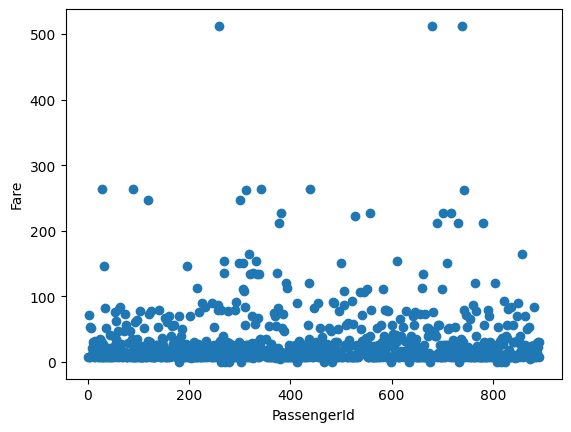

In [40]:
# 19. PassengerId, Fare
EDA_2D(df.PassengerId, df.Fare)

In [41]:
# 20. PassengerId, Cabin
EDA_2D(df.PassengerId, df.Cabin)

Feature Pair: ('PassengerId', 'Cabin')
Datatypes: ('int', 'string')
1:[]
891:[]


Feature Pair: ('PassengerId', 'Embarked')
Datatypes: ('int', 'string_class')
all:
Skewness: 0.0
Kurtosis: -1.1999999999999997
S
Skewness: -0.01181923722344943
Kurtosis: -1.2124062986884567
C
Skewness: -0.009966733284022422
Kurtosis: -1.1484531475221635
Q
Skewness: 0.11884115850083826
Kurtosis: -1.1495864663528015
nan
Skewness: nan
Kurtosis: nan


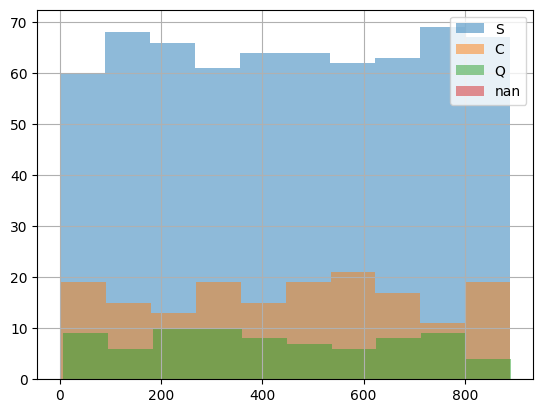

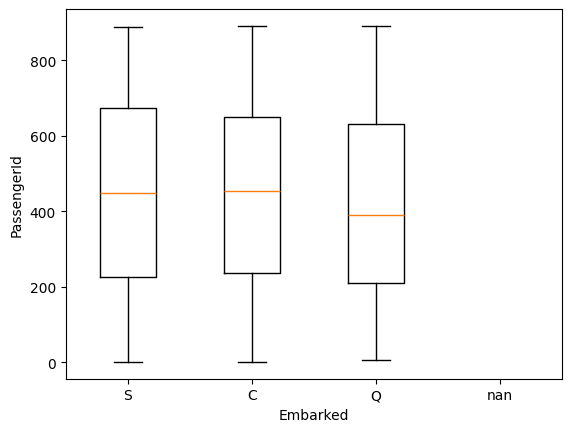

In [42]:
# 21. PassengerId, Embarked
EDA_2D(df.PassengerId, df.Embarked)

In [43]:
# 22. Pclass, Name
EDA_2D(df.Pclass, df.Name)

Feature Pair: ('Pclass', 'Name')
Datatypes: ('int_class', 'string')
Pclass  Name                         
1       Allen, Miss. Elisabeth Walton    1
3       Johansson, Mr. Karl Johan        1
        Jalsevac, Mr. Ivan               1
        Jansson, Mr. Carl Olof           1
        Jardin, Mr. Jose Neto            1
                                        ..
2       Hood, Mr. Ambrose Jr             1
        Hosono, Mr. Masabumi             1
        Hunt, Mr. George Henry           1
        Ilett, Miss. Bertha              1
3       van Melkebeke, Mr. Philemon      1
Name: count, Length: 891, dtype: int64
3:[('Mr.', 319), ('Miss.', 102), ('Mrs.', 42), ('Master.', 28), ('William', 23), ('John', 20), ('Johan', 14), ('Henry', 13), ('Thomas', 11), ('James', 10), ('Andersson,', 9), ('Anna', 9), ('Alfred', 9), ('Joseph', 9), ('Mary', 8), ('Karl', 8), ('Sage,', 7), ('George', 7), ('Johnson,', 6), ('Maria', 6)]
1:[('Mr.', 107), ('Miss.', 46), ('Mrs.', 42), ('William', 19), ('John', 13), (

In [44]:
# 23. Pclass, Sex
EDA_2D(df.Pclass, df.Sex)

Feature Pair: ('Pclass', 'Sex')
Datatypes: ('int_class', 'string_class')
Pclass  Sex   
3       male      347
        female    144
1       male      122
2       male      108
1       female     94
2       female     76
Name: count, dtype: int64


Feature Pair: ('Pclass', 'Age')
Datatypes: ('int_class', 'float')
Correlation: -0.3692260153155173
all:
Skewness: 0.38910778230082704
Kurtosis: 0.17827415364210353
3
Skewness: 0.48398975232858193
Kurtosis: 0.9945304367877648
1
Skewness: 0.11985744501915112
Kurtosis: -0.3587980527669634
2
Skewness: 0.13383744196510058
Kurtosis: 0.24453546058916764


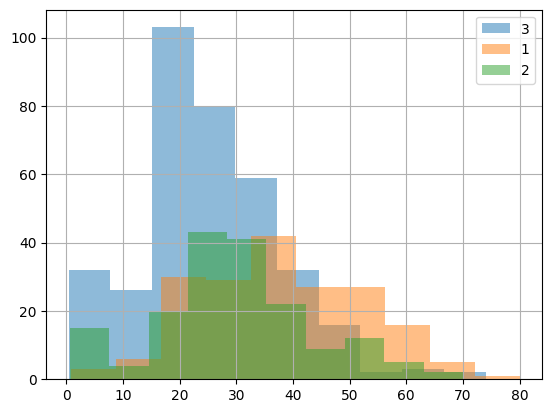

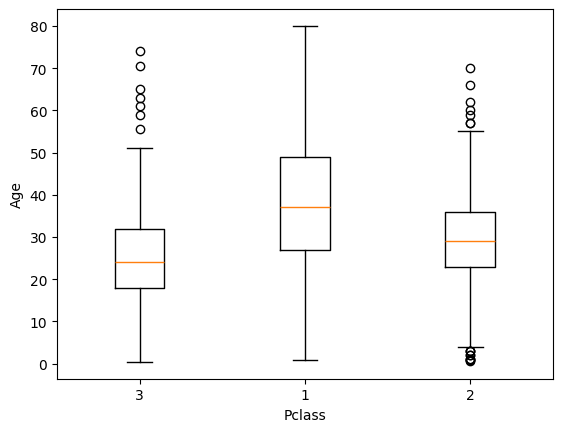

In [45]:
# 24. Pclass, Age
EDA_2D(df.Pclass, df.Age)

In [46]:
# 25. Pclass, SibSp
EDA_2D(df.Pclass, df.SibSp)

Feature Pair: ('Pclass', 'SibSp')
Datatypes: ('int_class', 'int_class')
Correlation: 0.08308136284568689
Pclass  SibSp
3       0        351
1       0        137
2       0        120
3       1         83
1       1         71
2       1         55
3       4         18
        2         15
        3         12
2       2          8
3       8          7
1       2          5
3       5          5
1       3          3
2       3          1
Name: count, dtype: int64


In [47]:
# 26. Pclass, Parch
EDA_2D(df.Pclass, df.Parch)

Feature Pair: ('Pclass', 'Parch')
Datatypes: ('int_class', 'int_class')
Correlation: 0.01844267131074855
Pclass  Parch
3       0        381
1       0        163
2       0        134
3       1         55
        2         43
2       1         32
1       1         31
        2         21
2       2         16
3       5          5
        3          3
        4          3
2       3          2
1       4          1
3       6          1
Name: count, dtype: int64


In [48]:
# 27. Pclass, Ticket
EDA_2D(df.Pclass, df.Ticket)

Feature Pair: ('Pclass', 'Ticket')
Datatypes: ('int_class', 'string')
Pclass  Ticket       
3       1601             7
        347082           7
        CA. 2343         7
        CA 2144          6
        3101295          6
                        ..
2       SC/PARIS 2146    1
        SC/PARIS 2149    1
        SC/PARIS 2167    1
        SC/Paris 2163    1
3       W./C. 6609       1
Name: count, Length: 681, dtype: int64
3:[('STON/O', 12), ('2.', 12), ('A/5', 10), ('C.A.', 8), ('SOTON/O.Q.', 8), ('CA.', 8), ('A/5.', 7), ('347082', 7), ('1601', 7), ('W./C.', 7), ('SOTON/OQ', 7), ('2343', 7), ('STON/O2.', 6), ('3101295', 6), ('CA', 6), ('2144', 6), ('347088', 6), ('382652', 5), ('C', 5), ('349909', 4)]
1:[('PC', 60), ('19950', 4), ('113781', 4), ('17421', 4), ('17757', 4), ('113760', 4), ('17572', 3), ('35273', 3), ('110152', 3), ('17755', 3), ('110413', 3), ('17582', 3), ('17760', 3), ('13502', 3), ('17474', 3), ('24160', 3), ('113803', 2), ('17569', 2), ('17604', 2), ('113789', 2)]


Feature Pair: ('Pclass', 'Fare')
Datatypes: ('int_class', 'float')
Correlation: -0.5494996199439082
all:
Skewness: 4.787316519674893
Kurtosis: 33.39814088089868
3
Skewness: 2.7360721038126665
Kurtosis: 8.248901128023991
1
Skewness: 2.835045438903401
Kurtosis: 11.239734268455791
2
Skewness: 2.0377803881395473
Kurtosis: 5.618794024162357


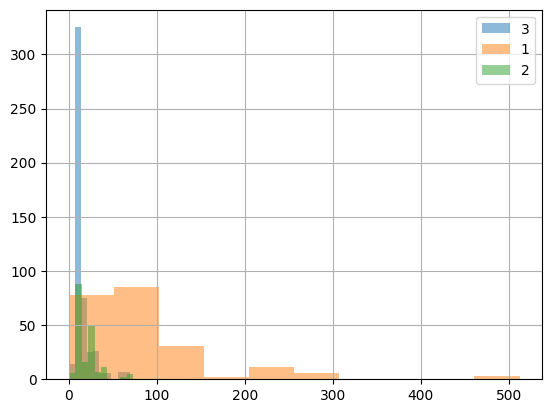

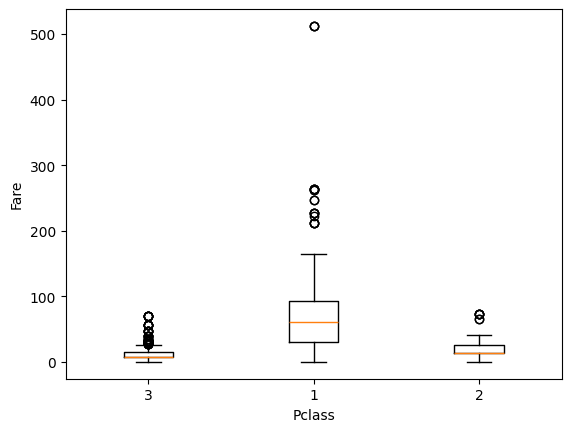

In [49]:
# 28. Pclass, Fare
EDA_2D(df.Pclass, df.Fare)

In [50]:
# 29. Pclass, Cabin
EDA_2D(df.Pclass, df.Cabin)

Feature Pair: ('Pclass', 'Cabin')
Datatypes: ('int_class', 'string')
Pclass  Cabin      
3       G6             4
1       B96 B98        4
        C23 C25 C27    4
2       D              3
        E101           3
                      ..
1       C101           1
        B94            1
        B86            1
        B82 B84        1
        C62 C64        1
Name: count, Length: 147, dtype: int64
3:[('G6', 4), ('F', 4), ('G73', 2), ('E121', 2), ('E69', 1), ('E10', 1), ('G63', 1), ('F38', 1)]
1:[('C23', 4), ('C25', 4), ('C27', 4), ('B96', 4), ('B98', 4), ('C22', 3), ('C26', 3), ('C123', 2), ('D33', 2), ('C52', 2), ('B28', 2), ('C83', 2), ('D26', 2), ('B58', 2), ('B60', 2), ('C2', 2), ('E33', 2), ('D36', 2), ('C93', 2), ('C78', 2)]
2:[('F33', 3), ('E101', 3), ('F2', 3), ('D', 3), ('F4', 2), ('D56', 1), ('E77', 1)]


In [51]:
# 30. Pclass, Embarked
EDA_2D(df.Pclass, df.Embarked)

Feature Pair: ('Pclass', 'Embarked')
Datatypes: ('int_class', 'string_class')
Pclass  Embarked
3       S           353
2       S           164
1       S           127
        C            85
3       Q            72
        C            66
2       C            17
        Q             3
1       Q             2
Name: count, dtype: int64


In [52]:
# 31. Name, Sex
EDA_2D(df.Name, df.Sex)

Feature Pair: ('Name', 'Sex')
Datatypes: ('string', 'string_class')
male:[('Mr.', 517), ('William', 47), ('Master.', 40), ('John', 36), ('Henry', 28), ('James', 20), ('George', 20), ('Charles', 19), ('Thomas', 15), ('Edward', 14), ('Johan', 13), ('Richard', 12), ('Arthur', 11), ('Alfred', 11), ('Joseph', 10), ('Frederick', 10), ('Jr', 9), ('Samuel', 9), ('Robert', 8), ('Karl', 8)]
female:[('Miss.', 182), ('Mrs.', 125), ('William', 15), ('Mary', 13), ('Anna', 11), ('Elizabeth', 9), ('John', 8), ('Margaret', 8), ('Maria', 7), ('(Elizabeth', 6), ('Andersson,', 6), ('Helen', 6), ('Joseph', 6), ('Sofia', 6), ('Thomas', 6), ('Alice', 6), ('Anne', 5), ('Henry', 5), ('(Anna', 5), ('Annie', 5)]


In [53]:
# 32. Name, Age
EDA_2D(df.Name, df.Age)

Feature Pair: ('Name', 'Age')
Datatypes: ('string', 'float')
0.42:[('Thomas,', 1), ('Master.', 1), ('Assad', 1), ('Alexander', 1)]
80.0:[('Barkworth,', 1), ('Mr.', 1), ('Algernon', 1), ('Henry', 1), ('Wilson', 1)]


In [54]:
# 33. Name, SibSp
EDA_2D(df.Name, df.SibSp)

Feature Pair: ('Name', 'SibSp')
Datatypes: ('string', 'int_class')
SibSp  Name                        
0      Abbing, Mr. Anthony             1
       Young, Miss. Marie Grice        1
       Wilhelms, Mr. Charles           1
       Willey, Mr. Edward              1
       Williams, Mr. Charles Duane     1
                                      ..
       Leitch, Miss. Jessie Wills      1
       Lemberopolous, Mr. Peter L      1
       Lemore, Mrs. (Amelia Milley)    1
       Leonard, Mr. Lionel             1
8      Sage, Mr. George John Jr        1
Name: count, Length: 891, dtype: int64
1:[('Mr.', 85), ('Mrs.', 75), ('Miss.', 30), ('William', 21), ('Master.', 15), ('John', 13), ('Joseph', 8), ('Henry', 8), ('Thomas', 7), ('Samuel', 6), ('Carter,', 6), ('Edward', 6), ('(Anna', 5), ('Frederick', 5), ('Johan', 4), ('Alexander', 4), ('Frank', 4), ('Charles', 4), ('Richard', 4), ('Ernest', 4)]
0:[('Mr.', 413), ('Miss.', 123), ('Mrs.', 45), ('William', 38), ('John', 30), ('James', 23), ('Henr

In [55]:
# 34. Name, Parch
EDA_2D(df.Name, df.Parch)

Feature Pair: ('Name', 'Parch')
Datatypes: ('string', 'int_class')
Parch  Name                                          
0      Abbing, Mr. Anthony                               1
       Strandberg, Miss. Ida Sofia                       1
       Spencer, Mrs. William Augustus (Marie Eugenie)    1
       Stahelin-Maeglin, Dr. Max                         1
       Staneff, Mr. Ivan                                 1
                                                        ..
       Johansson, Mr. Gustaf Joel                        1
       Johansson, Mr. Karl Johan                         1
       Johnson, Mr. Alfred                               1
       Johnson, Mr. Malkolm Joackim                      1
6      Goodwin, Mrs. Frederick (Augusta Tyler)           1
Name: count, Length: 891, dtype: int64
0:[('Mr.', 465), ('Miss.', 118), ('Mrs.', 69), ('William', 45), ('John', 31), ('Henry', 31), ('James', 22), ('Charles', 16), ('George', 16), ('Thomas', 16), ('Johan', 13), ('Edward', 12), ('A

In [56]:
# 35. Name, Ticket
EDA_2D(df.Name, df.Ticket)

Feature Pair: ('Name', 'Ticket')
Datatypes: ('string', 'string')
                                                Name            Ticket
0                            Braund, Mr. Owen Harris         A/5 21171
1  Cumings, Mrs. John Bradley (Florence Briggs Th...          PC 17599
2                             Heikkinen, Miss. Laina  STON/O2. 3101282
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)            113803
4                           Allen, Mr. William Henry            373450
                                         Name      Ticket
886                     Montvila, Rev. Juozas      211536
887              Graham, Miss. Margaret Edith      112053
888  Johnston, Miss. Catherine Helen "Carrie"  W./C. 6607
889                     Behr, Mr. Karl Howell      111369
890                       Dooley, Mr. Patrick      370376


In [57]:
# 36. Name, Fare
EDA_2D(df.Name, df.Fare)

Feature Pair: ('Name', 'Fare')
Datatypes: ('string', 'float')
0.0:[('Mr.', 14), ('William', 5), ('Henry', 2), ('Johnson,', 2), ('Jr', 2), ('Alfred', 2), ('Leonard,', 1), ('Lionel', 1), ('Harrison,', 1), ('Tornquist,', 1), ('Parkes,', 1), ('Francis', 1), ('"Frank"', 1), ('Cahoone', 1), ('Cunningham,', 1), ('Fleming', 1), ('Campbell,', 1), ('Frost,', 1), ('Anthony', 1), ('Wood', 1)]
512.3292:[('Mr.', 2), ('Ward,', 1), ('Miss.', 1), ('Anna', 1), ('Cardeza,', 1), ('Thomas', 1), ('Drake', 1), ('Martinez', 1), ('Lesurer,', 1), ('Gustave', 1), ('J', 1)]


In [58]:
# 37. Name, Cabin
EDA_2D(df.Name, df.Cabin)

Feature Pair: ('Name', 'Cabin')
Datatypes: ('string', 'string')
                                                Name Cabin
0                            Braund, Mr. Owen Harris   NaN
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   C85
2                             Heikkinen, Miss. Laina   NaN
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  C123
4                           Allen, Mr. William Henry   NaN
                                         Name Cabin
886                     Montvila, Rev. Juozas   NaN
887              Graham, Miss. Margaret Edith   B42
888  Johnston, Miss. Catherine Helen "Carrie"   NaN
889                     Behr, Mr. Karl Howell  C148
890                       Dooley, Mr. Patrick   NaN


In [59]:
# 38. Name, Embarked
EDA_2D(df.Name, df.Embarked)

Feature Pair: ('Name', 'Embarked')
Datatypes: ('string', 'string_class')
S:[('Mr.', 397), ('Miss.', 110), ('Mrs.', 90), ('William', 57), ('John', 34), ('Master.', 31), ('Henry', 29), ('Charles', 20), ('George', 18), ('James', 17), ('Edward', 16), ('Johan', 15), ('Frederick', 15), ('Richard', 13), ('Thomas', 13), ('Alfred', 12), ('Arthur', 10), ('Andersson,', 9), ('Ernest', 9), ('Samuel', 9)]
C:[('Mr.', 85), ('Miss.', 38), ('Mrs.', 31), ('Joseph', 8), ('John', 6), ('Master.', 5), ('y', 5), ('Marie', 4), ('Victor', 4), ('de', 4), ('Samuel', 4), ('Baclini,', 4), ('William', 3), ('Hanna', 3), ('Laroche,', 3), ('Henry', 3), ('Albert', 3), ('Boulos,', 3), ('James', 3), ('Elizabeth', 3)]
Q:[('Mr.', 35), ('Miss.', 33), ('Mary', 9), ('Thomas', 6), ('Rice,', 5), ('Patrick', 5), ('James', 4), ('Master.', 4), ('Katherine', 4), ('John', 4), ('Moran,', 3), ('Margaret', 3), ('Delia', 3), ("O'Brien,", 3), ('Mrs.', 3), ('Bourke,', 3), ('Hanora', 3), ('Eugene', 2), ('Anna', 2), ('Bridget', 2)]
nan:[]


Feature Pair: ('Sex', 'Age')
Datatypes: ('string_class', 'float')
all:
Skewness: 0.38910778230082704
Kurtosis: 0.17827415364210353
male
Skewness: 0.4753181256388725
Kurtosis: 0.35607169320554055
female
Skewness: 0.20609656437103183
Kurtosis: -0.3303356237591588


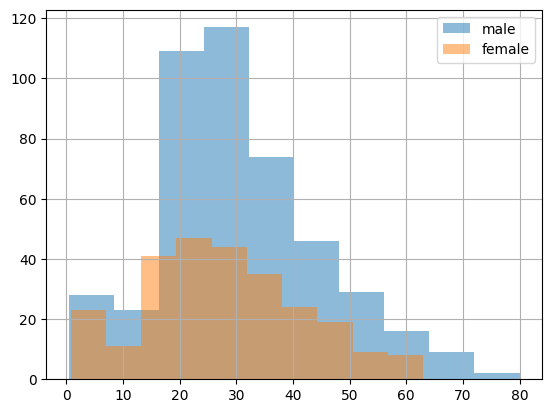

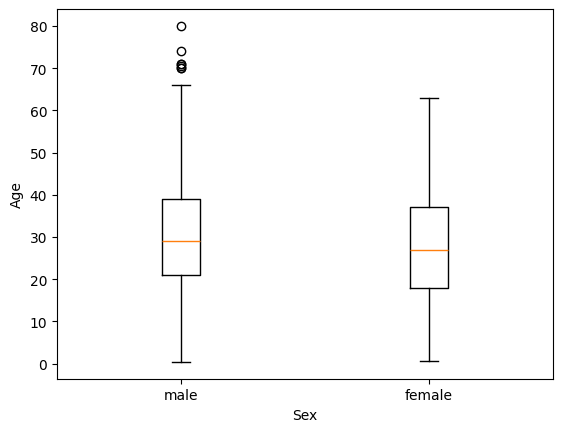

In [60]:
# 39. Sex, Age
EDA_2D(df.Sex, df.Age)

In [61]:
# 40. Sex, SibSp
EDA_2D(df.Sex, df.SibSp)

Feature Pair: ('Sex', 'SibSp')
Datatypes: ('string_class', 'int_class')
SibSp  Sex   
0      male      434
       female    174
1      female    106
       male      103
2      male       15
       female     13
4      male       12
3      female     11
4      female      6
3      male        5
5      male        4
8      male        4
       female      3
5      female      1
Name: count, dtype: int64


In [62]:
# 41. Sex, Parch
EDA_2D(df.Sex, df.Parch)

Feature Pair: ('Sex', 'Parch')
Datatypes: ('string_class', 'int_class')
Parch  Sex   
0      male      484
       female    194
1      female     60
       male       58
2      female     49
       male       31
3      female      4
5      female      4
4      female      2
       male        2
3      male        1
5      male        1
6      female      1
Name: count, dtype: int64


In [63]:
# 42. Sex, Ticket
EDA_2D(df.Sex, df.Ticket)

Feature Pair: ('Sex', 'Ticket')
Datatypes: ('string_class', 'string')
male:[('PC', 31), ('C.A.', 18), ('STON/O', 12), ('2.', 12), ('A/5', 10), ('1601', 7), ('SOTON/OQ', 7), ('SOTON/O.Q.', 7), ('A/5.', 5), ('3101295', 5), ('S.O.C.', 5), ('14879', 5), ('382652', 4), ('CA', 4), ('2144', 4), ('C', 4), ('SC/PARIS', 4), ('CA.', 4), ('2343', 4), ('LINE', 4)]
female:[('PC', 29), ('C.A.', 9), ('W./C.', 6), ('STON/O2.', 5), ('347082', 5), ('CA.', 4), ('F.C.C.', 4), ('2666', 4), ('349909', 3), ('6608', 3), ('347088', 3), ('2343', 3), ('4133', 3), ('110152', 3), ('13502', 3), ('113781', 3), ('17757', 3), ('24160', 3), ('347742', 2), ('PP', 2)]


Feature Pair: ('Sex', 'Fare')
Datatypes: ('string_class', 'float')
all:
Skewness: 4.787316519674893
Kurtosis: 33.39814088089868
male
Skewness: 6.62151491617816
Kurtosis: 61.29600812009731
female
Skewness: 3.2776225699972397
Kurtosis: 16.10058382243316


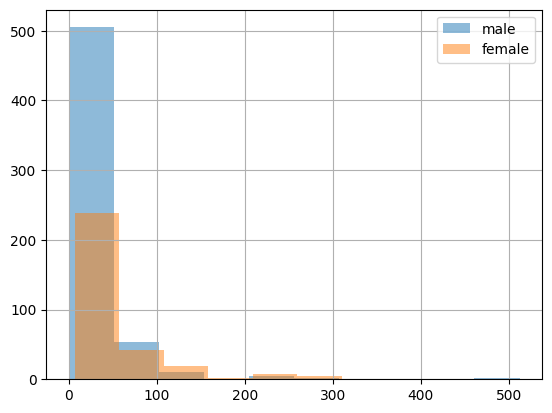

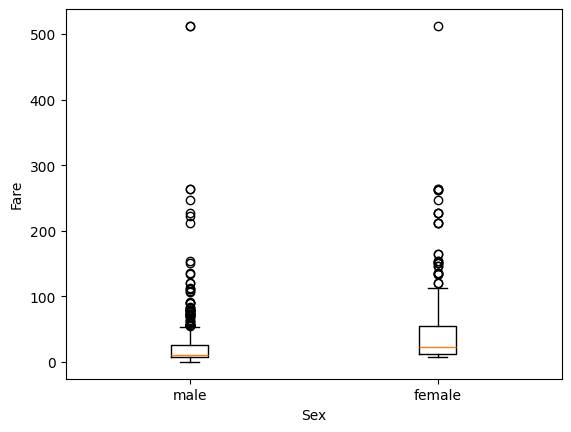

In [64]:
# 43. Sex, Fare
EDA_2D(df.Sex, df.Fare)

In [65]:
# 44. Sex, Cabin
EDA_2D(df.Sex, df.Cabin)

Feature Pair: ('Sex', 'Cabin')
Datatypes: ('string_class', 'string')
male:[('F', 3), ('F2', 3), ('C23', 2), ('C25', 2), ('C27', 2), ('C52', 2), ('G73', 2), ('D26', 2), ('C124', 2), ('B96', 2), ('B98', 2), ('E25', 2), ('B51', 2), ('B53', 2), ('B55', 2), ('E24', 2), ('E46', 1), ('D56', 1), ('A6', 1), ('B30', 1)]
female:[('G6', 4), ('F33', 3), ('E101', 3), ('B28', 2), ('C23', 2), ('C25', 2), ('C27', 2), ('E33', 2), ('D36', 2), ('B77', 2), ('C125', 2), ('C22', 2), ('C26', 2), ('B57', 2), ('B59', 2), ('B63', 2), ('B66', 2), ('D', 2), ('B18', 2), ('B35', 2)]


In [66]:
# 45. Sex, Embarked
EDA_2D(df.Sex, df.Embarked)

Feature Pair: ('Sex', 'Embarked')
Datatypes: ('string_class', 'string_class')
Sex     Embarked
male    S           441
female  S           203
male    C            95
female  C            73
male    Q            41
female  Q            36
Name: count, dtype: int64


Feature Pair: ('Age', 'SibSp')
Datatypes: ('float', 'int_class')
Correlation: -0.30824675892365644
all:
Skewness: 0.38910778230082704
Kurtosis: 0.17827415364210353
1
Skewness: -0.006911187167588952
Kurtosis: -0.2254542212708679
0
Skewness: 0.7073166895526694
Kurtosis: 0.5192705918162703
3
Skewness: 0.5244870951403056
Kurtosis: -1.3093379646371157
4
Skewness: 0.7784184318048035
Kurtosis: -0.28180475408389283
2
Skewness: 0.32318693467026893
Kurtosis: -0.2815275557773673
5
Skewness: -1.1286368288645516
Kurtosis: 1.3627838582711824
8
Skewness: nan
Kurtosis: nan


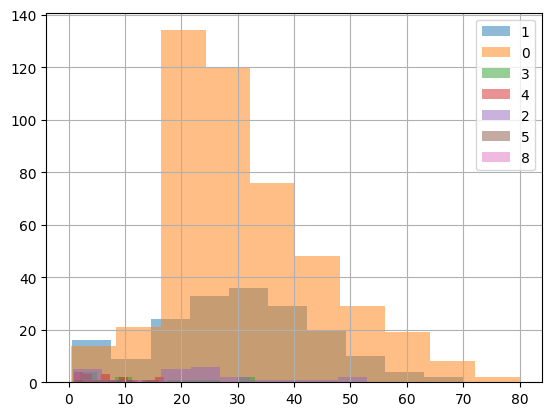

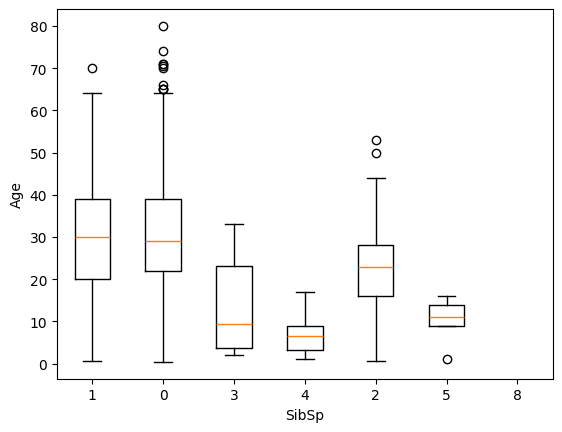

In [67]:
# 46. Age, SibSp
EDA_2D(df.Age, df.SibSp)

Feature Pair: ('Age', 'Parch')
Datatypes: ('float', 'int_class')
Correlation: -0.18911926263203516
all:
Skewness: 0.38910778230082704
Kurtosis: 0.17827415364210353
0
Skewness: 0.9496759366629428
Kurtosis: 0.5792726531531747
1
Skewness: 0.3568450304776126
Kurtosis: -0.8947801275785019
2
Skewness: 0.7433667238828509
Kurtosis: 0.11250975021459197
5
Skewness: 1.2932338163316295
Kurtosis: 2.9166666666666234
3
Skewness: 0.49969662190979147
Kurtosis: -2.5959967487951667
4
Skewness: 0.7684331280094286
Kurtosis: 1.301384099045709
6
Skewness: nan
Kurtosis: nan


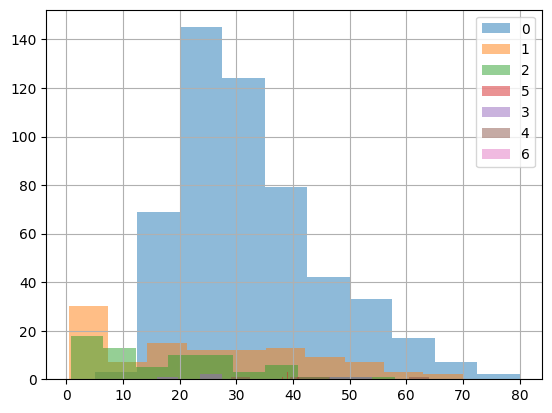

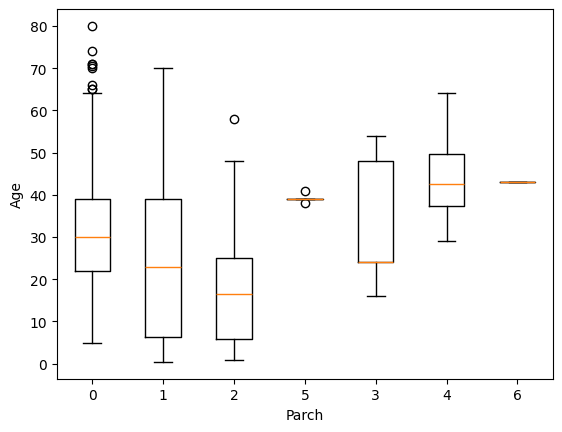

In [68]:
# 47. Age, Parch
EDA_2D(df.Age, df.Parch)

In [69]:
# 48. Age, Ticket
EDA_2D(df.Age, df.Ticket)

Feature Pair: ('Age', 'Ticket')
Datatypes: ('float', 'string')
0.42:[('2625', 1)]
80.0:[('27042', 1)]


Feature Pair: ('Age', 'Fare')
Datatypes: ('float', 'float')
Correlation: 0.09606669176903894


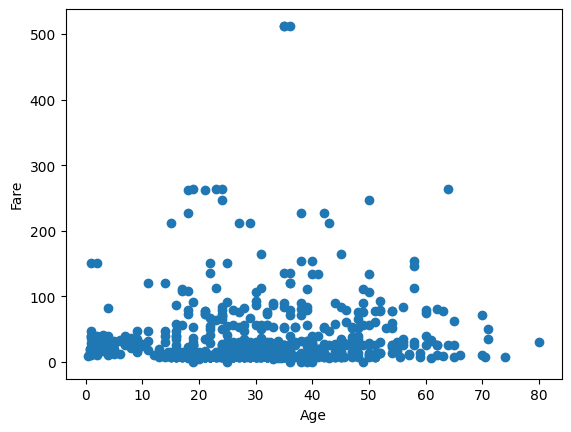

In [70]:
# 49. Age, Fare
EDA_2D(df.Age, df.Fare)

In [71]:
# 50. Age, Cabin
EDA_2D(df.Age, df.Cabin)

Feature Pair: ('Age', 'Cabin')
Datatypes: ('float', 'string')
0.42:[]
80.0:[('A23', 1)]


Feature Pair: ('Age', 'Embarked')
Datatypes: ('float', 'string_class')
all:
Skewness: 0.38910778230082704
Kurtosis: 0.17827415364210353
S
Skewness: 0.3674497255104596
Kurtosis: 0.276773255016058
C
Skewness: 0.3385840093916499
Kurtosis: -0.17383347755482736
Q
Skewness: 0.8360390015918041
Kurtosis: 0.6910843645877893
nan
Skewness: nan
Kurtosis: nan


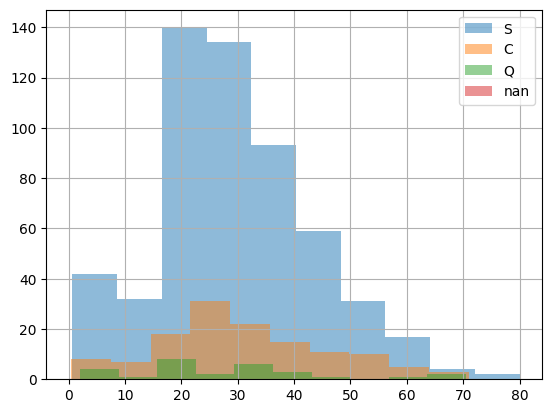

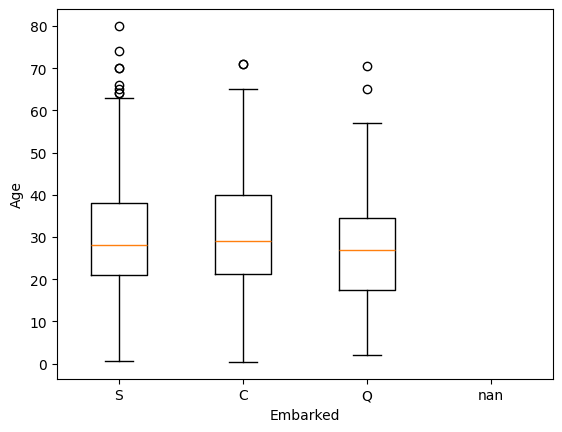

In [72]:
# 51. Age, Embarked
EDA_2D(df.Age, df.Embarked)

In [73]:
# 52. SibSp, Parch
EDA_2D(df.SibSp, df.Parch)

Feature Pair: ('SibSp', 'Parch')
Datatypes: ('int_class', 'int_class')
Correlation: 0.41483769862015646
SibSp  Parch
0      0        537
1      0        123
       1         57
0      1         38
       2         29
1      2         19
2      0         16
4      2          9
       1          9
3      2          7
       1          7
2      1          7
8      2          7
5      2          5
2      2          4
1      5          3
       4          3
       3          3
3      0          2
0      5          2
2      3          1
0      4          1
       3          1
1      6          1
Name: count, dtype: int64


In [74]:
# 53. SibSp, Ticket
EDA_2D(df.SibSp, df.Ticket)

Feature Pair: ('SibSp', 'Ticket')
Datatypes: ('int_class', 'string')
SibSp  Ticket  
8      CA. 2343    7
0      1601        7
5      CA 2144     5
4      347082      5
       3101295     5
                  ..
0      347468      1
       347470      1
       347742      1
       347743      1
       368323      1
Name: count, Length: 731, dtype: int64
1:[('PC', 14), ('C.A.', 13), ('W./C.', 4), ('113760', 4), ('SC/Paris', 3), ('2123', 3), ('34651', 3), ('A/5.', 3), ('STON/O2.', 3), ('113781', 3), ('113803', 2), ('237736', 2), ('347082', 2), ('17604', 2), ('113789', 2), ('2651', 2), ('11668', 2), ('349237', 2), ('17572', 2), ('36973', 2)]
0:[('PC', 43), ('C.A.', 14), ('STON/O', 11), ('2.', 11), ('A/5', 9), ('SOTON/O.Q.', 8), ('1601', 7), ('SOTON/OQ', 7), ('C', 5), ('A/5.', 4), ('LINE', 4), ('STON/O2.', 3), ('A/4.', 3), ('SC/PARIS', 3), ('F.C.C.', 3), ('W./C.', 3), ('110152', 3), ('17755', 3), ('17582', 3), ('17760', 3)]
3:[('347088', 4), ('4133', 4), ('349909', 3), ('19950', 3), ('31012

Feature Pair: ('SibSp', 'Fare')
Datatypes: ('int_class', 'float')
Correlation: 0.1596510432421609
all:
Skewness: 4.787316519674893
Kurtosis: 33.39814088089868
1
Skewness: 2.0375763157173146
Kurtosis: 5.671888164465283
0
Skewness: 6.020135244278891
Kurtosis: 47.84214416593791
3
Skewness: 1.766686397207003
Kurtosis: 1.275130698468435
4
Skewness: -1.918897478059962
Kurtosis: 6.504050144734998
2
Skewness: 2.5564013918589996
Kurtosis: 6.279847919436688
5
Skewness: 0.0
Kurtosis: 0.0
8
Skewness: 0.0
Kurtosis: 0.0


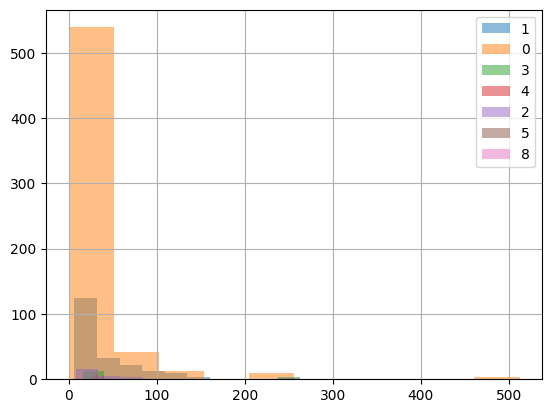

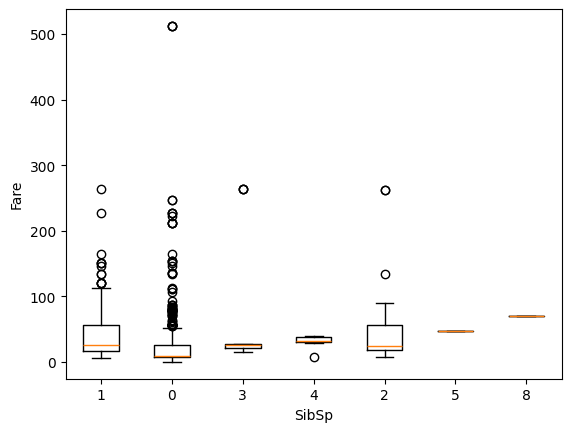

In [75]:
# 54. SibSp, Fare
EDA_2D(df.SibSp, df.Fare)

In [76]:
# 55. SibSp, Cabin
EDA_2D(df.SibSp, df.Cabin)

Feature Pair: ('SibSp', 'Cabin')
Datatypes: ('int_class', 'string')
SibSp  Cabin      
1      B96 B98        4
0      F33            3
1      C22 C26        3
0      D              3
3      C23 C25 C27    3
                     ..
0      C32            1
       C30            1
       C148           1
       C128           1
       D56            1
Name: count, Length: 152, dtype: int64
1:[('B96', 4), ('B98', 4), ('C22', 3), ('C26', 3), ('C123', 2), ('G6', 2), ('D33', 2), ('C83', 2), ('C2', 2), ('F2', 2), ('D36', 2), ('C93', 2), ('D35', 2), ('E67', 2), ('B49', 2), ('C65', 2), ('E44', 2), ('C92', 2), ('D20', 2), ('C68', 2)]
0:[('F33', 3), ('F', 3), ('E101', 3), ('D', 3), ('C52', 2), ('B28', 2), ('G73', 2), ('D26', 2), ('B58', 2), ('B60', 2), ('E33', 2), ('G6', 2), ('B77', 2), ('C125', 2), ('B18', 2), ('C124', 2), ('B35', 2), ('E25', 2), ('B51', 2), ('B53', 2)]
3:[('C23', 3), ('C25', 3), ('C27', 3)]
4:[]
2:[('F4', 2), ('B57', 2), ('B59', 2), ('B63', 2), ('B66', 2), ('C78', 1), ('C101', 1

In [77]:
# 56. SibSp, Embarked
EDA_2D(df.SibSp, df.Embarked)

Feature Pair: ('SibSp', 'Embarked')
Datatypes: ('int_class', 'string_class')
SibSp  Embarked
0      S           438
1      S           145
0      C           109
       Q            59
1      C            53
2      S            19
3      S            16
4      S            14
1      Q            11
8      S             7
2      C             6
5      S             5
4      Q             4
2      Q             3
Name: count, dtype: int64


In [78]:
# 57. Parch, Ticket
EDA_2D(df.Parch, df.Ticket)

Feature Pair: ('Parch', 'Ticket')
Datatypes: ('int_class', 'string')
Parch  Ticket      
2      CA. 2343        7
0      1601            7
1      3101295         5
2      347082          5
0      S.O.C. 14879    5
                      ..
       345774          1
       345777          1
       345778          1
       345779          1
6      CA 2144         1
Name: count, Length: 722, dtype: int64
0:[('PC', 48), ('C.A.', 13), ('STON/O', 12), ('2.', 12), ('A/5', 10), ('SOTON/O.Q.', 8), ('1601', 7), ('SOTON/OQ', 7), ('STON/O2.', 6), ('A/5.', 6), ('S.O.C.', 5), ('14879', 5), ('C', 5), ('SC/PARIS', 5), ('LINE', 4), ('17757', 4), ('A/4.', 3), ('17572', 3), ('371110', 3), ('W./C.', 3)]
1:[('PC', 10), ('C.A.', 8), ('3101295', 5), ('382652', 4), ('4133', 4), ('349909', 3), ('2666', 3), ('2661', 2), ('231919', 2), ('35281', 2), ('17558', 2), ('33112', 2), ('113505', 2), ('347742', 2), ('230136', 2), ('364849', 2), ('230080', 2), ('347054', 2), ('11751', 2), ('230433', 2)]
2:[('CA.', 7), ('234

Feature Pair: ('Parch', 'Fare')
Datatypes: ('int_class', 'float')
Correlation: 0.2162249447707648
all:
Skewness: 4.787316519674893
Kurtosis: 33.39814088089868
0
Skewness: 6.1171312099902515
Kurtosis: 57.17592455116079
1
Skewness: 4.367500224899932
Kurtosis: 25.4855232551025
2
Skewness: 1.9439237114483574
Kurtosis: 3.132552981602078
5
Skewness: 1.919196100257971
Kurtosis: 4.107236433548481
3
Skewness: 0.42537028181824127
Kurtosis: -3.1457776702555575
4
Skewness: 1.9955673726772583
Kurtosis: 3.9856050517800377
6
Skewness: nan
Kurtosis: nan


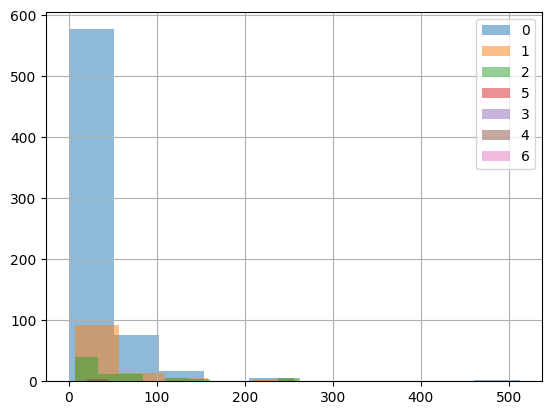

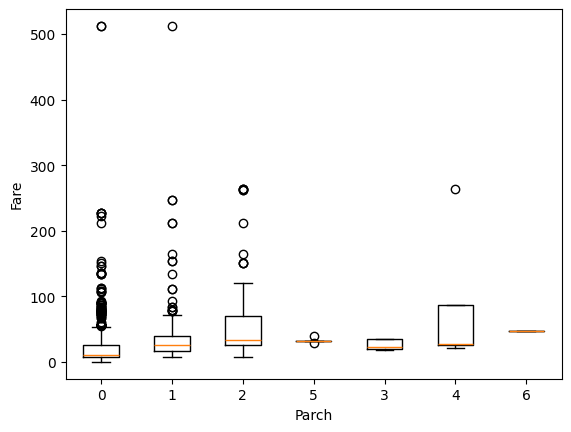

In [79]:
# 58. Parch, Fare
EDA_2D(df.Parch, df.Fare)

In [80]:
# 59. Parch, Cabin
EDA_2D(df.Parch, df.Cabin)

Feature Pair: ('Parch', 'Cabin')
Datatypes: ('int_class', 'string')
Parch  Cabin      
2      B96 B98        4
0      E101           3
1      G6             3
0      D              3
2      C23 C25 C27    3
                     ..
0      C128           1
       C125           1
       C111           1
       C110           1
4      C23 C25 C27    1
Name: count, Length: 154, dtype: int64
0:[('F33', 3), ('F', 3), ('E101', 3), ('D', 3), ('C123', 2), ('D33', 2), ('C52', 2), ('B28', 2), ('C83', 2), ('G73', 2), ('C2', 2), ('D36', 2), ('C93', 2), ('C78', 2), ('B77', 2), ('B49', 2), ('C65', 2), ('C124', 2), ('B35', 2), ('E44', 2)]
1:[('G6', 3), ('D26', 2), ('B58', 2), ('B60', 2), ('E33', 2), ('F4', 2), ('F2', 2), ('D35', 2), ('E67', 2), ('B18', 2), ('C68', 2), ('E121', 2), ('B30', 1), ('D10', 1), ('D12', 1), ('F', 1), ('E69', 1), ('C125', 1), ('C118', 1), ('E34', 1)]
2:[('B96', 4), ('B98', 4), ('C23', 3), ('C25', 3), ('C27', 3), ('C22', 3), ('C26', 3), ('B57', 2), ('B59', 2), ('B63', 2), ('B66

In [81]:
# 60. Parch, Embarked
EDA_2D(df.Parch, df.Embarked)

Feature Pair: ('Parch', 'Embarked')
Datatypes: ('int_class', 'string_class')
Parch  Embarked
0      S           484
       C           123
1      S            82
0      Q            69
2      S            65
1      C            30
2      C            14
1      Q             6
3      S             4
4      S             4
5      S             4
2      Q             1
3      C             1
5      Q             1
6      S             1
Name: count, dtype: int64


In [82]:
# 61. Ticket, Fare
EDA_2D(df.Ticket, df.Fare)

Feature Pair: ('Ticket', 'Fare')
Datatypes: ('string', 'float')
0.0:[('LINE', 4), ('239853', 3), ('112059', 1), ('239854', 1), ('112052', 1), ('239856', 1), ('239855', 1), ('112050', 1), ('112058', 1), ('19972', 1)]
512.3292:[('PC', 3), ('17755', 3)]


In [83]:
# 62. Ticket, Cabin
EDA_2D(df.Ticket, df.Cabin)

Feature Pair: ('Ticket', 'Cabin')
Datatypes: ('string', 'string')
             Ticket Cabin
0         A/5 21171   NaN
1          PC 17599   C85
2  STON/O2. 3101282   NaN
3            113803  C123
4            373450   NaN
         Ticket Cabin
886      211536   NaN
887      112053   B42
888  W./C. 6607   NaN
889      111369  C148
890      370376   NaN


In [84]:
# 63. Ticket, Embarked
EDA_2D(df.Ticket, df.Embarked)

Feature Pair: ('Ticket', 'Embarked')
Datatypes: ('string', 'string_class')
S:[('C.A.', 27), ('PC', 14), ('STON/O', 12), ('2.', 12), ('A/5', 10), ('W./C.', 9), ('SOTON/O.Q.', 8), ('CA.', 8), ('347082', 7), ('1601', 7), ('SOTON/OQ', 7), ('2343', 7), ('STON/O2.', 6), ('A/5.', 6), ('3101295', 6), ('CA', 6), ('2144', 6), ('347088', 6), ('S.O.C.', 5), ('14879', 5)]
C:[('PC', 46), ('SC/PARIS', 5), ('SC/Paris', 4), ('17421', 4), ('17757', 4), ('2666', 4), ('2123', 3), ('17572', 3), ('35273', 3), ('17755', 3), ('237736', 2), ('17569', 2), ('17604', 2), ('2651', 2), ('2661', 2), ('2665', 2), ('2627', 2), ('17558', 2), ('2668', 2), ('17593', 2)]
Q:[('382652', 5), ('371110', 3), ('370365', 2), ('364849', 2), ('367230', 2), ('19928', 2), ('367226', 2), ('330877', 1), ('330923', 1), ('330959', 1), ('335677', 1), ('330958', 1), ('370371', 1), ('14311', 1), ('330932', 1), ('370369', 1), ('370372', 1), ('365222', 1), ('35851', 1), ('368703', 1)]
nan:[]


In [85]:
# 64. Fare, Cabin
EDA_2D(df.Fare,df.Cabin)

Feature Pair: ('Fare', 'Cabin')
Datatypes: ('float', 'string')
0.0:[('B94', 1), ('A36', 1), ('B102', 1)]
512.3292:[('B51', 1), ('B53', 1), ('B55', 1), ('B101', 1)]


Feature Pair: ('Fare', 'Embarked')
Datatypes: ('float', 'string_class')
all:
Skewness: 4.787316519674893
Kurtosis: 33.39814088089868
S
Skewness: 3.6487804818455203
Kurtosis: 16.633494585925035
C
Skewness: 3.3349624101899544
Kurtosis: 13.96080141286448
Q
Skewness: 4.350320543007908
Kurtosis: 21.38133684990386
nan
Skewness: nan
Kurtosis: nan


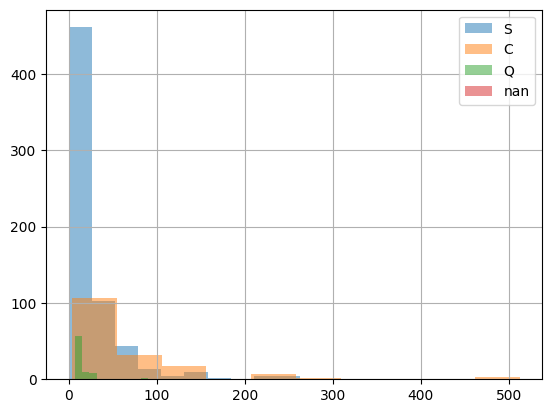

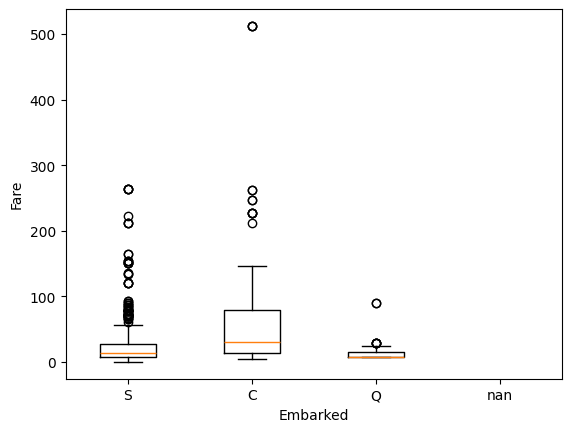

In [86]:
# 65. Fare, Embarked
EDA_2D(df.Fare, df.Embarked)

In [87]:
# 66. Cabin, Embarked
EDA_2D(df.Cabin, df.Embarked)

Feature Pair: ('Cabin', 'Embarked')
Datatypes: ('string', 'string_class')
S:[('G6', 4), ('C23', 4), ('C25', 4), ('C27', 4), ('B96', 4), ('B98', 4), ('F33', 3), ('F', 3), ('F2', 3), ('C22', 3), ('C26', 3), ('C123', 2), ('C52', 2), ('C83', 2), ('G73', 2), ('D26', 2), ('E101', 2), ('C2', 2), ('E33', 2), ('F4', 2)]
C:[('D33', 2), ('B58', 2), ('B60', 2), ('D36', 2), ('B49', 2), ('D', 2), ('C65', 2), ('B57', 2), ('B59', 2), ('B63', 2), ('B66', 2), ('B18', 2), ('B35', 2), ('C92', 2), ('D20', 2), ('C68', 2), ('C85', 1), ('B78', 1), ('B30', 1), ('A5', 1)]
Q:[('C78', 2), ('E101', 1), ('F38', 1)]
nan:[]


In [111]:
# Feature Engineering Stage
# We separate X and y, then start a pipeline to do appropriate preprocessing
X = df.drop('Survived', axis=1)
y = df['Survived']

# X
# PassengerId - int64
# Pclass - int64 (ternary)
# Name - string
# Sex - string (binary)
# Age - float64
# SibSp - int64
# Parch - int64
# Ticket - string
# Fare - float64
# Cabin - string
# Embarked - string (ternary)
#
#
# y
# Survived - int64 (binary)


# First, drop passengerId - just leaks info on position in dataset, not correlated with survival at all.
# Second, one hot encode Pclass.
# Third, get some Name features (TBD)
# Fourth, one hot encode Sex
# Fifth, standard scaler on age, SibSp, Parch, and Fare

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer([
    ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore"), ["Pclass", "Sex"]),
    ("SimpleImputer", SimpleImputer(add_indicator=True), ["Age", "SibSp", "Parch", "Fare"]),
    ("StandardScalar", StandardScaler(), ["Age", "SibSp", "Parch", "Fare"]),
])
pipe = Pipeline([("preprocessor", preprocessor)])
print(X)
print(pipe.fit_transform(X))
pipe.get_feature_names_out()

     PassengerId  Pclass                                               Name  \
0              1       3                            Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2              3       3                             Heikkinen, Miss. Laina   
3              4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                           Allen, Mr. William Henry   
..           ...     ...                                                ...   
886          887       2                              Montvila, Rev. Juozas   
887          888       1                       Graham, Miss. Margaret Edith   
888          889       3           Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                              Behr, Mr. Karl Howell   
890          891       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket  

array(['OneHotEncoder__Pclass_1', 'OneHotEncoder__Pclass_2',
       'OneHotEncoder__Pclass_3', 'OneHotEncoder__Sex_female',
       'OneHotEncoder__Sex_male', 'SimpleImputer__Age',
       'SimpleImputer__SibSp', 'SimpleImputer__Parch',
       'SimpleImputer__Fare', 'SimpleImputer__missingindicator_Age',
       'StandardScalar__Age', 'StandardScalar__SibSp',
       'StandardScalar__Parch', 'StandardScalar__Fare'], dtype=object)

In [89]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64